![](https://miro.medium.com/max/3840/1*LHuN1tJt-abIpuX14v5M8w.png)

-----------------------------
Notebook stats:
- takes 30 minutes with Kaggle CPU
- notebook for rapid prototyping with 3200Mhz and 3GHz CPU
- Expected to reach hitrate of 80 in validation
- Use 400GB server and uncomment all features for 85% hitrate, mse: 0.2-0.21200
- XGB 0.22198 but only after 11h+ with depth 14 xgb takes 8,5h
- Neural Network: mse: 0.15?
-----------------------------

This is yet another starter notebook for the [Numerai Signals](https://signals.numer.ai/).

What we do here includes:

- fetch US stock price data via YFinance API
- merge the data with the Numerai Signals' historical targets
- perform feature engineering (considering stational features)
- modeling with XGBoost
- submit (if you want)

In a kaggle dataset [YFinance Stock Price Data for Numerai Signals](https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals), I fetch the stock price data on a daily basis via the YFinance API. So if you are bothered using the API for yourself, just use this dataset (it must be up-to-date).

This content is largely inspired by the following starter.

>End to end notebook for Numerai Signals using completely free data from Yahoo Finance, by Jason Rosenfeld (jrAI).

https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3

#round562 node2: start 14:19,2min used to turn LGBM off

## Install Pandas using CUDF (100x speedup with GPU + less memory failures)

### First restart the runtime
### Goes automatically through popup on colab

In [ ]:
#!pip install plotly-express

# Libraries
Let's import what we need...

In [ ]:
!pip3 install numerapi --upgrade
!pip install pandas --upgrade
!pip install requests
!pip install tabulate
!pip install future
!pip install colorama>=0.3.8
!pip install six
#!wget http://h2o-release.s3.amazonaws.com/h2o/rel-zygmund/1/h2o-3.38.0.1.zip
#!unzip h2o-3.38.0.1.zip
#!cd h2o-3.38.0.1/
#!bin/sparkling-shell --num-executors 3 --executor-memory 2g --master yarn --deploy-mode client

#!pip install zipfile

#!pip install --no-index finta --find-links file:../input/finta-package
!pip install matplotlib_venn
!pip3 install pyarrow
!pip install --upgrade pip
!pip install -U graphviz #for visualizing boosting trees
!pip install joblib

!pip install seaborn

# ML packages
!pip install h2o_pysparkling_3.2
#!pip install h2o_pysparkling_3.4
!pip install xgboost
!pip install lightgbm
!pip install scikit-learn
!pip uninstall neptune-client -y
!pip uninstall neptune -y
!pip install scikit-learn #!pip install neptune-client neptune-xgboost
!pip install neptune
!pip install neptune-xgboost
#!pip install -U ne#https://docs.h2o.ai/sparkling-water/3.3/latest-stable/doc/pysparkling.html
# downgrade pyspark installation to adhere to sparkling-water setup (node 1)

# Computing packages
!pip install pyspark==3.2.2
!pip install pysparklingptune-lightgbm
!pip install dask[full]
!pip uninstall jinja2 -y
!pip install jinja2 --upgrade
#!pip install graphviz

# Could take 5min

Found existing installation: neptune 1.11.1
Uninstalling neptune-1.11.1:
  Successfully uninstalled neptune-1.11.1
  Using cached neptune-1.11.1-py3-none-any.whl.metadata (16 kB)
Using cached neptune-1.11.1-py3-none-any.whl (501 kB)
ERROR: Could not find a version that satisfies the requirement pysparklingptune-lightgbm (from versions: none)
ERROR: No matching distribution found for pysparklingptune-lightgbm
Found existing installation: Jinja2 3.1.4
Uninstalling Jinja2-3.1.4:
  Successfully uninstalled Jinja2-3.1.4
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.4.5 requires bokeh<3.5.0,>=3.4.0, but you have bokeh 3.5.2 which is incompatible.


In [ ]:
use_gpu = 1
if use_gpu == 1:
  !pip uninstall cudf-cu12 -y
  !pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com

Found existing installation: cudf-cu12 24.4.1
Uninstalling cudf-cu12-24.4.1:
  Successfully uninstalled cudf-cu12-24.4.1
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


### Restart Runtime in Colab

In [ ]:
!pip install --upgrade pyarrow

  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (39.9 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu11 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf-cu11 24.8.2 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
cudf-cu11 24.8.2 requires pyarrow<16.2.0a0,>=16.1.0, but you have pyarrow 17.0.0 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
use_gpu = 1
if use_gpu == 1:
  %load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [ ]:

#get_ipython().kernel.do_shutdown(restart=True)

### Data API


1. Yahoo Finance: package yfinance

In [ ]:
!pip install numerapi

from numerapi import SignalsAPI
api = SignalsAPI()
api.download_dataset(
	"signals/v1.0/train.parquet",
	"train.parquet"
)
api.download_dataset(
	"signals/v1.0/validation.parquet",
	"validation.parquet"
)
api.download_dataset(
	"signals/v1.0/live.parquet",
	"live.parquet"
)
api.download_dataset(
	"signals/v1.0/live_example_preds.parquet",
	"live_example_preds.parquet"
)
api.download_dataset(
	"signals/v1.0/validation_example_preds.parquet",
	"validation_example_preds.parquet"
)

'validation_example_preds.parquet'

In [ ]:
### replace Tickers for yahoo download

In [ ]:
import yfinance as yf

def get_revenue(ticker):
  """
  This function takes a ticker symbol and attempts to retrieve revenue data from Yahoo Finance.

  Args:
      ticker: Ticker symbol for the company on Yahoo Finance (e.g., "ING.AX")

  Returns:
      Revenue in millions as a float or None if not found.
  """
  try:
    # Download financial data for the ticker
    company_info = yf.Ticker(ticker)
    # Access annual financials
    financials = company_info.financials
    # Check if revenue data is available
    if "Revenue" in financials:
      return financials["Revenue"].iloc[0] / 1e6  # Convert to millions
    else:
      return None
  except (yf.DownloadError, KeyError):
    # Handle errors gracefully
    return None

# Sample usage
tickers = [
  "ING.AX",
  "BKL.AX",
  "CUV.AX",
  "COH.AX",
  "PXA.AX"
]

for ticker in tickers:
  revenue = get_revenue(ticker)
  if revenue:
    print(f"{ticker} revenue: {revenue:.2f} million")
  else:
    print(f"Revenue not found for {ticker}")

Revenue not found for ING.AX
Revenue not found for BKL.AX
Revenue not found for CUV.AX
Revenue not found for COH.AX
Revenue not found for PXA.AX


In [ ]:
#!pip install quandl

In [ ]:
#import quandl

In [ ]:
#!pip install nasdaq-data-link
#import nasdaqdatalink

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#nasdaqdatalink.read_key(filename="/content/drive/MyDrive/Data/API/apikeyndq")

In [ ]:
#data = nasdaqdatalink.get_table('MER/F1', compnumber=["39102" , "2438"], paginate=True)

In [ ]:
#data2 = nasdaqdatalink.get_table('MER/F1', compnumber="39102", paginate=True)
#print(data)
#print(data2)

### CBS Data

In [ ]:
!pip install cbsodata

In [ ]:
### Use data

In [ ]:
!pip install --upgrade numpy
!pip install scikit-learn

  Using cached numpy-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.1.0 which is incompatible.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 2.1.0 which is incompatible.
arviz 0.18.0 requires numpy<2.0,>=1.23.0, but you have numpy 2.1.0 which is incompatible.
cudf-cu11 24.8.2 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.0 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.0 which is incompatible.
gensim 4.3.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
import timeit
import numerapi
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import pathlib
from tqdm.auto import tqdm
import joblib
import json
import scipy.stats as stats
#from sklearn.decomposition import PCA, FactorAnalysis
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
#from sklearn import preprocessing
from multiprocessing import Pool, cpu_count
import time
import requests as re
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR
# Execution time of the model start
startnb = datetime.now()
#import dask.dataframe as dd
#from sklearn.preprocessing import LabelEncoder
import tracemalloc as tm
import os

# models
#from sklearn import utils, metrics
#from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import operator

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import graphviz
from xgboost import plot_tree
sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.simplefilter('ignore')

In [ ]:
import neptune as neptune
from neptune.new.integrations.xgboost import NeptuneCallback
neptune_switch = 0 #0 is off
if neptune_switch == 1:
    run = neptune.init(
        project="develuse/Signals",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwM2Q3YWQ5MC0zZDA2LTRlOTgtOWRmMC1lNzc0NjIwYjUwZTgifQ==",
    )  # your credentials

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


# Config
A simple config and logging setup.
To update the Kaggle dataset set DATASET to 1 in config

In [ ]:
today = datetime.now().strftime('%Y-%m-%d')
today

'2024-08-30'

In [ ]:
today_yyyymmdd = datetime.now().strftime('%Y%m%d')
today_yyyymmdd

'20240830'

In [ ]:
# config class
class CFG:
    """
    Set FETCH_VIA_API = True if you want to fetch the data via API.
    Otherwise we use the daily-updated one in the kaggle dataset (faster).
    """
    INPUT_DIR = '../../Signals/Data/'
    #INPUT_DIR = '../input/yfinance-stock-price-data-for-numerai-signals/' #Kaggle
    OUTPUT_DIR = '../../Signals/Submission/'
    LOG = 0
    DATASET = 1 #use in Colab, upload Kaggle api key an duse to update Kaggle dataset to Drive
    EDS_DATE = 20231010
    FUN_DATE = 20230929
    FETCH_VIA_API = False
    SEED = 46
    DEBUG = False # True, test mode using small set of tickers
    RUN = "lgb_4D_10y_testpoly"
    DS_OVERRIDE = 1
    DS = 629
    TYPE = "C" #K:Katsu, E:EDS, G:Kaggle Katsu, C:Colab Katsu, CKK: Colab Kaggle Katsu
    START = 634 #100
    END = 1980
    STARTDATE = 20130101
    ENDDATE = today_yyyymmdd
    XGB_DEPTH = 6 #was 5 #check if its faster as 14
    XGB = 0
    LGBM = 1
    H2O = 0
    H2O_RUNTIME = 6000 #600/10min 24000/6h40m
    H2O_ALGOS = ['XGBoost','StackedEnsemble','GBM']#, 'DeepLearning', 'DRF', 'GLM', ,
                   #include_algos = ['DRF', 'GLM', 'XGBoost', 'GBM', 'DeepLearning'],
    ANALYSE = 1 # a lot of prints, lgbm nonrandom feature df parquet, histogram, validation
    LEAN = 1 # for deleting variables along the way, 1 deletes them all
#3800 for sharpe 6
#round562 node2 100-4300 (to stay within 1:40 hours) 2011 stocks
#round565 node2: 634-4300 rmse 0.239; 5000
#569node2: 5300
#573node2: 9:20 start
#574node2: 12:22 start, hang 4h30m on xgb
#575node2: 6150 with 1994 hangs on 1.4tb; 6040 worked;
#578node2: 4800 #579node2: 5353 2700 stocks; 5453
#580node2: K5390 ok;
#581node2: start 11:30 13:52 kernel died; 14:12 start with 5460->5350 17:06:05 complete; 20:35 5430
#583node2: 5425 kernel died; 5400 start 13:10  kerneld died at 500GB? 14:40; 5300 kernel died; 5200 15:05
#589node2: 6535 19:05
#590node2: 5435 kernel died; K5395 OK; K5405 OK; K5415
#593node2: 5431 kernel died; 5429
#594node2: 1.5144TBram K5479 OK
#599node2: 5495 server reset; 5480

In [ ]:
%%time
'''
if CFG.DATASET == 1:
    !pip install -q kaggle
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d develuse/signals-326 --force
    !kaggle datasets download -d code1110/yfinance-stock-price-data-for-numerai-signals
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    import zipfile
    zip_ref = zipfile.ZipFile('signals-326.zip', 'r')
    zip_ref.extractall('/content/drive/MyDrive/Kaggle/Signals')
    zip_ref = zipfile.ZipFile('yfinance-stock-price-data-for-numerai-signals.zip', 'r')
    zip_ref.extractall('/content/drive/MyDrive/Signals/Data/Market')
    zip_ref.close()
    #TODO: rename full_data to full_data{current_ds}
    !mv /content/drive/MyDrive/Signals/Data/Market/full_data.parquet /content/drive/MyDrive/Signals/Data/Market/{CFG.DS}.parquet
''
#614kaggle: 2m1s
#615kaggle: 2m32s; 629 1m13s

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
403 - Forbidden - Permission 'datasets.get' was denied
Dataset URL: https://www.kaggle.com/datasets/code1110/yfinance-stock-price-data-for-numerai-signals
License(s): other
 99% 447M/451M [00:15<00:00, 27.9MB/s]
100% 451M/451M [00:15<00:00, 29.8MB/s]
Mounted at /content/drive/


FileNotFoundError: [Errno 2] No such file or directory: 'signals-326.zip'

In [ ]:
%%time
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
if CFG.LOG == 1:
    logger = init_logger(log_file=f'{CFG.OUTPUT_DIR}/log/{today}.log')
    logger.info('Start Logging...')
#581: 4h16m 2023-09-27 21:26:59 - 2023-09-28 01:45:08
#583:  2023-09-29 15:05:05 -
#589: 17:51:39 20:05:04 2h 13m; 10:24:06 - 04:34:21 6h10m
#590node2: 5 min till here first run after boot, 11:01:28 - 13:00 2h
#590node2: K5395 14:32:07 15:56:16 1h25m9s; 16:11:33 - 17:48:36 1h37m3s
# 19:19:40 - 20:50:47 1h31m7s

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.8 µs


# Setup Numerai API
First of all, let's set up the numerai signals API.

We can do many things with this API:

- get a ticker map (between yfinance data and numerai historical targets)
- get the historical targets
- get your model slot name and model_id (if private key and secret key are provided)
- submit

(well, maybe more)

## Get Tickers for Numerai Signals
Let's first get the ticker map.

In [ ]:
%%time
napi = numerapi.SignalsAPI()
if CFG.LOG == 1:
    logger.info('numerai api setup!')

CPU times: user 70 µs, sys: 0 ns, total: 70 µs
Wall time: 73.9 µs


In [ ]:
%%time
# read in list of active Signals tickers which can change slightly era to era
internet=1
if internet==1: #1: internet available
    eligible_tickers = pd.Series(napi.ticker_universe(), name='ticker')
    if CFG.LOG == 1:
          logger.info(f"Number of eligible tickers: {len(eligible_tickers)}")
eligible_tickers.to_csv(f'/content/drive/MyDrive/Signals/Data/eligible_tickers_{today_yyyymmdd}.csv')
#590node2: K5400 1.03s

signals/v1.0/live.parquet: 721kB [00:00, 1.02MB/s]                          


CPU times: user 96.2 ms, sys: 13.2 ms, total: 109 ms
Wall time: 2 s


In [ ]:
%%time
#TODO: replace this with EDS tickermap
# read in yahoo to numerai ticker map, still a work in progress, h/t wsouza and
# this tickermap is a work in progress and not guaranteed to be 100% correct
if internet==1:
    ticker_map = pd.read_csv('https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv')
    ticker_map = ticker_map[ticker_map.bloomberg_ticker.isin(eligible_tickers)]
#else:
    #ticker_map = pd.read_parquet('ticker_map.parquet')
#print(ticker_map.shape)
#ticker_map.head()
numerai_tickers = ticker_map['ticker']
yfinance_tickers = ticker_map['yahoo']
#logger.info(f"Number of eligible tickers in map: {len(ticker_map)}")
#590node2: 1.23s

CPU times: user 26.1 ms, sys: 2.03 ms, total: 28.1 ms
Wall time: 914 ms


This ticker map is necessary for a successful submission if you use yfinance data.

# Load Stock Price Data
Now is the time to get the stock price data, fetched via the [YFiance API](https://pypi.org/project/yfinance/).

The good thing with this API is that it is free of charge.

The bad thing with this API is that the data is often not complete.

For a better quality of stock price data, you might want to try out purchasing one from [Quandl](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/documentation?anchor=overview).

This is another starter using Quandl data:
https://forum.numer.ai/t/signals-plugging-in-the-data-from-quandl/2431

This is of course wonderful, but if you are a beginner, why not just start with a free one?

In [ ]:
%%time
napi2 = numerapi.NumerAPI(verbosity="info")
if CFG.DS_OVERRIDE == 1:
    current_ds=CFG.DS
else:
    if internet==1:
        current_ds = napi2.get_current_round()
    else:
        current_ds=CFG.DS

print('Current round: ',current_ds)

Current round:  629
CPU times: user 2.11 ms, sys: 0 ns, total: 2.11 ms
Wall time: 2.06 ms


## Adapt dataframe for weekday
if it is a weekday we need to use the last day instead of the last available friday
to do this we
we determine the friday date
we determine the last weekday
we check if we have this last weekday for each friday date
*if we don't have a last weekday we need to see if we have other weekdays after the friday date to replace it or keep the friday date
remove the friday date from the dataframe
replace the last weekday by the friday date
replace the original dataframe

## Data Store with categorical and static data like country GICS shares(place to dynamic later)

In [ ]:
%%time
if CFG.TYPE == "C":
  EDS = pd.read_csv(f'/content/drive/MyDrive/Kaggle/Signals/EDS_20230824.csv')
elif CFG.TYPE == "CKK":
  EDS = pd.read_csv(f'/content/drive/MyDrive/Kaggle/Signals/EDS_20230824.csv')
else:
  EDS = pd.read_csv(f'{CFG.INPUT_DIR}/EDS_{CFG.EDS_DATE}.csv')
#EDS = pd.read_csv(f'../input/signals-{current_ds}/EDS_202207.csv') #Kaggle

CPU times: user 25.4 ms, sys: 7.06 ms, total: 32.5 ms
Wall time: 36.1 ms


## Data Store with dynamic fundamental data

In [ ]:
%%time
if CFG.TYPE == "C":
  FUN = pd.read_csv(f'/content/drive/MyDrive/Kaggle/Signals/FUN_20230929.csv')
elif CFG.TYPE == "CKK":
  FUN = pd.read_csv(f'/content/drive/MyDrive/Kaggle/Signals/FUN_20230929.csv')
else:
  FUN = pd.read_csv(f'{CFG.INPUT_DIR}/Fundamental/FUN_{CFG.FUN_DATE}.csv')

CPU times: user 15.7 ms, sys: 893 µs, total: 16.6 ms
Wall time: 19.7 ms


In [ ]:
#TODO: test Write tickers with yahoodata available to file
#pd.DataFrame(df.ticker.unique()).to_csv('yahoo_downloaded_tickers.csv')
#TODO: check why not all eligible are downloaded

### Merge EDS with FUN


### Only merge with timeperiods 45 days after end of period else it is foreward looking bias

In [ ]:
%%time
FUN.rename(columns={"ticker": "yahoo"}, inplace=True)
EDS.rename(columns={"yahoo identifier": "yahoo"}, inplace=True)
EDS = EDS.merge(FUN,how='left', on=['yahoo'])
EDS.columns = EDS.columns.str.replace(".", "_")
if CFG.ANALYSE == 1:
    print(EDS.head())
    print(EDS.columns)

  bloomberg_ticker  Active                              Name website  \
0          VTOL US     1.0   https://www.bloomberg.com/quote/VTOL:US   
1           OFG US     1.0    https://www.bloomberg.com/quote/OFG:US   
2          LISN SW     1.0   https://www.bloomberg.com/quote/LISN:SW   
3          6289 JP     0.0   https://www.bloomberg.com/quote/6289:JP   
4         FCNCA US     1.0  https://www.bloomberg.com/quote/FCNCA:US   

  BB_exch_code                         Name  GICS_subindustry       shares  \
0           US                BRISTOW GROUP          10101020   27,983,000   
1           US                  OFG BANCORP          40101015  183,900,000   
2           SW               LINDTSPRUENGLI          30202030    159300000   
3           JP                        Giken          20106020            0   
4           US  FIRST CITIZENS BCSHS  -CL A          40201040  160,400,000   

   shares_update_date   shares_source Country_of_domicile  ...  \
0          20230820.0  company_r

## Load Targets for Numerai Signals
For a supervised machine learning, we need a target label. That is available in the Numerai Signals, so we can just fetch it.

Note that there are 2 target columns: 'target' and 'target_20d'. 'target' is often referred as 'target_4d', which is a shorter target.

Values for target_4d and target_20d become available after they have resolved, 11 and 33 days respectively from round open. target_20d takes longer to resolve, and so the most recent dates will have a value of NaN for target_20d, while target_4d will not.

target_20d is what your Signal is evaluated against for scoring and payouts, so we use 'target_20d' in this starter notebook.

In [ ]:
%%time

targets = pd.read_parquet('live_example_preds.parquet')
tickers = targets.numerai_ticker
tickers_unique = tickers.unique()
tickers_unique = pd.DataFrame(tickers_unique)
print(tickers_unique)
tickers_unique.to_csv('tickers_unique_live.csv')
#4min58s
#round369 node3: 15.8GB 5min31s
#round549 node1: 54s
#568node1: 4m30s
#568node1: TODO: URLError: <urlopen error [Errno -3] Temporary failure in name resolution> 24m55s
#569node1: 2m2s
#572node2: took too long
#573node2: 3min46s
#583node2: 1m46s
#589node2: 2m27s
#590node2: 1m51s

              0
0     000080 KR
1     000100 KR
2     000120 KR
3     000150 KR
4     000210 KR
...         ...
4891      ZV IT
4892    ZVRA US
4893     ZWS US
4894    ZYME US
4895     ZZZ CA

[4896 rows x 1 columns]
CPU times: user 14.6 ms, sys: 1.9 ms, total: 16.5 ms
Wall time: 17.2 ms


In [ ]:
targets = pd.read_parquet('live_example_preds.parquet')

targets.to_csv('live_example_preds.csv')

### download targets

In [ ]:
%%time
# convert to numerai ticker, if the target ticker is not
if 'bloomberg_ticker' in targets.columns.values.tolist():
    targets['ticker'] = targets['bloomberg_ticker'].map(
        dict(zip(ticker_map['bloomberg_ticker'], ticker_map['ticker']))
    )
if 'bloomberg_ticker' not in targets.columns.values.tolist():
    targets['bloomberg_ticker'] = targets['ticker'].map(
        dict(zip(ticker_map['ticker'], ticker_map['bloomberg_ticker']))
    )
if CFG.ANALYSE == 1:
    print(targets.shape, targets['friday_date'].min(), targets['friday_date'].max())
#targets.head()
#583node2: 1s
#589node2: 1.08s
#590node2: 1.4s

KeyError: 'ticker'

KeyError: 'target_20d'

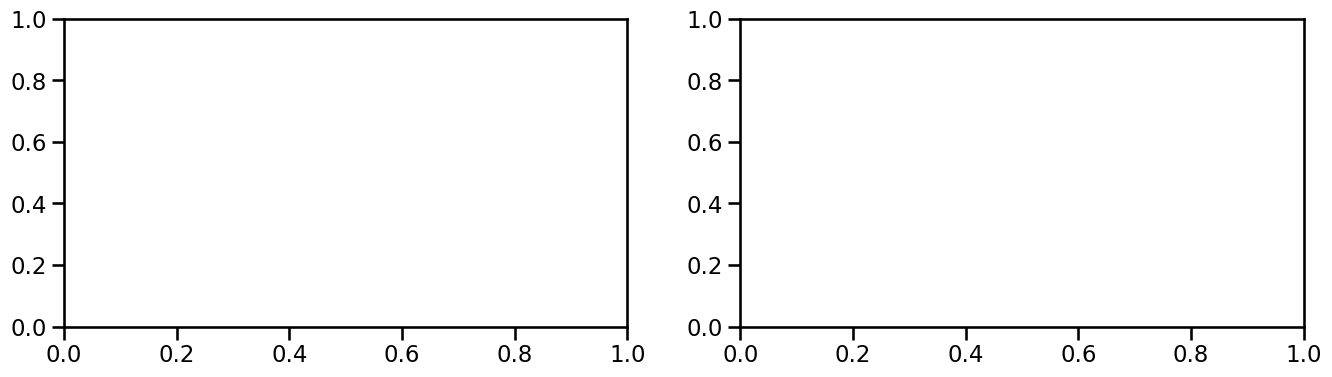

In [ ]:
%%time
if CFG.ANALYSE == 1:
    # there are train and validation...
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax = ax.flatten()

    for i, data_type in enumerate(['train', 'validation']):
        # slice
        targets_ = targets.query(f'data_type == "{data_type}"')
        """
        logger.info('*' * 50)
        logger.info('{} target: {:,} numerai tickers , {:,} bloomberg tickers (friday_date: {} - {})'.format(
            data_type,
            targets_['ticker'].nunique(),
            targets_['bloomberg_ticker'].nunique(),
            targets_['friday_date'].min(),
            targets_['friday_date'].max(),
        ))
        """
        # plot target
    #     ax[i].hist(targets_['target'])
        ax[i].hist(targets_['target_20d'])
        ax[i].set_title(f'{data_type}')

In [ ]:
%%time
d= []
if CFG.ANALYSE == 1:
    # target relations
    d = pd.crosstab(
        targets['target_4d']
        , targets['target_20d']
    )
    d['sum'] = d.values.sum(axis=1)
    for i, f in enumerate(d.columns):
        d[f] = d.apply(lambda row : 100*row[f]/row['sum'], axis=1)
    d.drop(columns=['sum'], inplace=True)

    print('target transition matrix (%)')
    d.astype(int).style.background_gradient(cmap='viridis', axis=1)
#583node2: 4.46s; 3.32s

NameError: name 'targets' is not defined

The target looks exactly like the one from the Numerai Tournament, where both features and targets are given to the participants.

Also note that the train-validation split is based on time (i.e., Time-Series Split):

- train friday_date: 20030131 ~ 20121228
- validation friday_date: 20130104 ~

## Check Ticker Overlaps
Let's see if we have enough overlap of tickers between our yfiance stock data and the numerai targets. We need at least 5 tickers for submission.

In [ ]:
%%time
if CFG.ANALYSE == 1:
    # ticker overlap
    venn3(
        [
            set(df['ticker'].unique().tolist())
            , set(targets.query('data_type == "train"')['ticker'].unique().tolist())
            , set(targets.query('data_type == "validation"')['ticker'].unique().tolist())
        ],
        set_labels=('yf price', 'train target', 'valid target')
    )
#583node2: 7.32s

NameError: name 'df' is not defined

Ah, yeah, not bad, I guess?

Here I only use our stock price data which have ticker overlaps such that we can build a supervised machine learning model.

In [ ]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage before optimization 2 is: {:.2f} MB'.format(start_mem))
    #print("The dataframe 2 has {} columns.".format(df.shape[1]))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    start_mem = end_mem
    #print('Memory usage after optimization 2 is: {:.2f} MB'.format(end_mem))
    #print("The reduced dataframe 2 has {} columns.".format(df.shape[1]))
    return df

In [ ]:
%%time
targets = reduce_mem_usage(targets)
#583node2: 6.32s; 5.94s
#589node2: 6138T 6.15s
#590node2: 6.85s
#594node2: 8.1s

NameError: name 'targets' is not defined

In [ ]:
%%time
# select target-only tickers
df = df.loc[df['ticker'].isin(targets['ticker'])].reset_index(drop=True)
if CFG.ANALYSE == 1:
    print('{:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))
#583node2: 14.7s; 12.6s
#589node2: 6138T 12.9s
#590node2: 12.2s
#594node2: 17.4s

NameError: name 'df' is not defined

As I mentioned earlier, the yfiance stock data is not complete. Let's see if we have enough records per ticker.

In [ ]:
%%time
record_per_ticker = df.groupby('ticker')['date'].nunique().reset_index().sort_values(by='date')
#record_per_ticker
#583node2: 27.2s; 23.7s
#589node2: 6138T 29.5s
#590node2: 25.9s
#594node2: 33.8s

NameError: name 'df' is not defined

In [ ]:
%%time
if CFG.ANALYSE == 1:
    record_per_ticker['date'].hist()
#print(record_per_ticker['date'].describe())

NameError: name 'record_per_ticker' is not defined

There are unfortunately some tickers where the number of records is small.

Here I only use tickers with more than 1,000 records.

In [ ]:
%%time
if CFG.ANALYSE == 1:
    print(CFG.START)
    print(CFG.END)
    ## Dataframe statistics
    print(df.shape)
    print(df.describe())
    print(df.info())
    print(df.ticker)
#583node2: 1.1GB 40.7s; 5400 (18942554, 8) 1.1GB 33.3s

634
1980


NameError: name 'df' is not defined

In [ ]:
%%time
#TODO: check need for DEBUG
if CFG.DEBUG: # debug mode, using small set of data
    tickers_with_records = record_per_ticker.query(f'date >= {CFG.START} & date < {CFG.END}')['ticker'].values
    #tickers_with_records = tickers_with_records.query('date < 3430')['ticker'].values
else:
    tickers_with_records = record_per_ticker.query(f'date >= {CFG.START} & date < {CFG.END}')['ticker'].values
    #tickers_with_records = tickers_with_records.query('date < 3430')['ticker'].values
df_full = df
df = df_full.loc[df_full['ticker'].isin(tickers_with_records)].reset_index(drop=True)
del df_full

## Dataframe statistics
if CFG.ANALYSE == 1:
    print(df.shape)
    print(df.describe())
    print(df.info())
    print('Here, we use {:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))

#round348 node3: 1000-4600 2205 stocks 4,647,601 records
#round355 node3: 3000-5000
#round368 node3: 1500-4800 501 stocks 1,643,778 records
#574node2: 440MB
#580node2: 318.1MB
#583node2: 409.7MB 5s; ANALYSE=0 4.32s
#589node2: 6138T 11.2s
#590node2: 4.17s
#594node2: 11.2s

NameError: name 'record_per_ticker' is not defined

In [ ]:
%%time
#EDS= EDS.rename(columns={'bloomberg_ticker':'ticker'})
EDSdf = df.merge(EDS,how='left',on='ticker')

## Dataframe statistics
if CFG.ANALYSE == 1:
    print(EDSdf.shape)
    print(EDSdf.describe())
    print(EDSdf.info())
    print('Here, we use {:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))
del df
gc.collect()
#574node2: 2487 stocks
#575node2: 4608 1.1GB (20874395,7)
#583node2: 5400 409.7MB (6712970,8) 2152 tickers 50.9s ANALYSE=0 55.2s
#586node2: all 10y 3m8s
#589node2: 6138T 2m19s
#590node2: 39.8s 2831
#594node2: 3m3s

NameError: name 'df' is not defined

### Data preparation

In [ ]:
%%time
# Fill NaN values in the 'shares' column with 1000000
EDSdf['shares'] = EDSdf['shares'].fillna(1000000)
EDSdf['sector'] = EDSdf['sector'].fillna('unknown')
EDSdf['industry'] = EDSdf['industry'].fillna('unknown')
#TODO: numerical labelencode, have blanks filled, first try if the blanks just get labeled
EDSdf['priceToBook_raw'] = EDSdf['priceToBook_raw'].fillna(1) #TODO: adjust 'priceToBook_raw' so it is numerical/int got error of xgboost
#EDSdf['lastFiscalYearEnd_raw'] = EDSdf['lastFiscalYearEnd_raw'].fillna(1000000)
EDSdf['earningsQuarterlyGrowth_raw'] = EDSdf['earningsQuarterlyGrowth_raw'].fillna(1000000)
EDSdf['revenueGrowth_raw'] = EDSdf['revenueGrowth_raw'].fillna(0.01)
EDSdf['grossMargins_raw'] = EDSdf['grossMargins_raw'].fillna(0.2)
EDSdf['profitMargins_raw'] = EDSdf['profitMargins_raw'].fillna(0.1)
# Dividends
EDSdf['payoutRatio_raw'] = EDSdf['payoutRatio_raw'].fillna(0.1)
EDSdf['dividendRate_raw'] = EDSdf['dividendRate_raw'].fillna(0.05)
EDSdf['dividendYield_raw'] = EDSdf['dividendYield_raw'].fillna(0.05)
EDSdf['fiveYearAvgDividendYield_raw'] = EDSdf['fiveYearAvgDividendYield_raw'].fillna(0.02)
EDSdf['trailingAnnualDividendRate_raw'] = EDSdf['trailingAnnualDividendRate_raw'].fillna(0.04)
EDSdf['trailingAnnualDividendYield_raw'] = EDSdf['trailingAnnualDividendYield_raw'].fillna(0.04)
#TODO: build elastic net imputer
# Convert 'shares' column to numeric, and then round and convert to int
EDSdf['shares'] = pd.to_numeric(EDSdf['shares'], errors='coerce').fillna(1000000).round().astype(int)

# Filter rows with shares greater than 0
df = EDSdf[EDSdf['shares'] > 0]

# Only keep fridays
df = df.set_index('date')
#df = df[df.index.weekday == 4]  # ensure we have only fridays
full_data = df
if CFG.LEAN == 1:
    del df, EDSdf, EDS
    gc.collect()
if CFG.ANALYSE == 1:
    full_data.info()
#583node2: 5425 3.4GB; 5200 ok; 5400 2.9GB 58s; 56.4s; 1m1s
#TODO: set last weekday of dataset as a friday before only keeping fridays
#586node2: all 10y 4m5s
#589node2: 6138T 3m37s
#590node2: 42.9s
#594node2: 3m30s

NameError: name 'EDSdf' is not defined

In [ ]:
#print(EDSdf.GICS_subindustry.head())

In [ ]:
%%time
full_data['GICS_1']= full_data['GICS_subindustry'].apply(lambda x: str(x)[:2])
full_data['GICS_2']= full_data['GICS_subindustry'].apply(lambda x: str(x)[:4])
full_data['GICS_3']= full_data['GICS_subindustry'].apply(lambda x: str(x)[:6])
#583node2: 13.4s
#586node2: 59s
#589node2: 6138T 37.8s
#590node2: 20.2s
#594node2: 47s

NameError: name 'full_data' is not defined

In [ ]:
%%time
if CFG.ANALYSE == 1:
    print(full_data.GICS_2.unique())

NameError: name 'full_data' is not defined

## possibility to subsample/ filter

In [ ]:
## Select semiconductors based on Industry

#filter on GICS 4 character Industry Group full_data['GICS_2'] = 4530
#full_data = full_data[full_data['GICS_2'] == '4530']
#round559 64 stocks

In [ ]:
%%time
# Import label encoder
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'.
full_data['GICS_1']= label_encoder.fit_transform(full_data['GICS_1'])
full_data['GICS_2']= label_encoder.fit_transform(full_data['GICS_2'])
full_data['GICS_3']= label_encoder.fit_transform(full_data['GICS_3'])
full_data['GICS_subindustry']= label_encoder.fit_transform(full_data['GICS_subindustry'])
# Fit and transform the country, currency and ISIN columns
full_data.rename(columns={"Country_of_risk_name": "CountryRisk_name"}, inplace=True)
full_data.rename(columns={"Country_of_domicile": "CountryDomicile_ISO2"}, inplace=True)

full_data['CountryRisk_name'] = label_encoder.fit_transform(full_data['CountryRisk_name'])
full_data['CountryDomicile_ISO2'] = label_encoder.fit_transform(full_data['CountryDomicile_ISO2'])
full_data['Currency'] = label_encoder.fit_transform(full_data['Currency'])
full_data['ISIN_code'] = label_encoder.fit_transform(full_data['ISIN_code'])
full_data['sector'] = label_encoder.fit_transform(full_data['sector'])
full_data['industry'] = label_encoder.fit_transform(full_data['industry'])
#575node2: 30GB in memory here with peak of 50GB 1m59s
#581node2: 17.8S
#583node2: 17.7s; 26.1s
#586node2: all 10y 1m25s
#589node2: 6138T 1m15s
#590node2: 30.4s
#594node2: 1m15s

NameError: name 'preprocessing' is not defined

In [ ]:
#full_data['Country_of_risk_name']= label_encoder.fit_transform(full_data['Country_of_risk_name'])
#full_data['ISIN_code']= label_encoder.fit_transform(full_data['ISIN_code'])
#full_data['Name']= label_encoder.fit_transform(full_data['Name'])
KEEP_FEAT = ['ticker', 'Name', 'investment_id','target_4d','target_20d','SEDOL']

In [ ]:
%%time
# save result dataframe
full_data.reset_index(inplace=True)
#full_data.astype('float32', errors='ignore').to_parquet(pathlib.Path(f'{CFG.OUTPUT_DIR}/stock_f_tgt_encoded_data.parquet'))
# Check dataframe min date, max date, day count, number of stocks
if CFG.ANALYSE == 1:
    print(full_data.groupby('ticker')['date'].agg(['min', 'max', 'count']))
    print(full_data.isnull().sum())
df = full_data
if CFG.LEAN == 1:
    del full_data
    gc.collect()
#round 332 node1:2 months of data
#581node2:11.5S
#583node2: 12.6s; 16.2s; ANALYSE=0 2s
#586node2: all 10y4.93s
#589node2: 6138T 2.31s

NameError: name 'full_data' is not defined

In [ ]:
def expand_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage before optimization 2 is: {:.2f} MB'.format(start_mem))
    #print("The dataframe 2 has {} columns.".format(df.shape[1]))
    halfs = ['int16','float16']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in halfs:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    start_mem = end_mem
    #print('Memory usage after optimization 2 is: {:.2f} MB'.format(end_mem))
    #print("The reduced dataframe 2 has {} columns.".format(df.shape[1]))
    return df

In [ ]:
%%time
#df = reduce_mem_usage(df)
if CFG.ANALYSE == 1:
    print(df.info())
#df.dtypes
#575node2: 8.6GB dataset
#580node2: 2GB
#df = reduce_mem_usage(df)
#581node2: 2.1GB
#583node2: 2.1GB; 3GB

NameError: name 'df' is not defined

In [ ]:
# Install pycaret
#!pip install scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl
#!pip install scikit-learn==0.23.2
#import sys
#sys.path.append('pycaret-master/pycaret-master')
#sys.path.append('pyod-master/pyod-master')

In [ ]:
%%time
# first, fix date column in the yfiance stock data to be friday date (just naming along with numerai targets)
#df['friday_date'] = df['date'].apply(lambda x : int(str(x).replace('-', '')))

## change date different for owm data from yahoofinance
df['friday_date'] = df['date'].apply(lambda x: str(x).replace('-', ''))#.dt.normalize()

#print(df.head())
#print(df.dtypes)
# takes some time till memory release of df merged with EDS
gc.collect()
#586node2: 23s
#589node2: 6138T 12.3s
#590node2: 7.93s
#594node2: 17s

NameError: name 'df' is not defined

In [ ]:
%%time
if CFG.LEAN == 1:
    del record_per_ticker, d, ticker_map
    gc.collect()
#583node2: 1.77s
#586node2: 4.46s
#589node2: 6138T 1.68s

NameError: name 'record_per_ticker' is not defined

In [ ]:
%%time
# recent friday date?
recent_friday = datetime.now() + relativedelta(weekday=FR(-1))
recent_friday = int(recent_friday.strftime('%Y%m%d'))
if CFG.ANALYSE == 1:
    print(f'Most recent Friday: {recent_friday}')

Most recent Friday: 20240830
CPU times: user 966 µs, sys: 0 ns, total: 966 µs
Wall time: 1.96 ms


In [ ]:
%%time
# in case no recent friday is available...prep the second last
recent_friday2 = datetime.now() + relativedelta(weekday=FR(-2))
recent_friday2 = int(recent_friday2.strftime('%Y%m%d'))
if CFG.ANALYSE == 1:
    print(f'Second most recent Friday: {recent_friday2}')

Second most recent Friday: 20240823
CPU times: user 800 µs, sys: 0 ns, total: 800 µs
Wall time: 897 µs


In [ ]:
# fix market-not-open-on-Friday problem
"""
    if np.sum(df['friday_date'] == recent_friday) < 4000:
        previous_tickers = set(df.query('friday_date == @recent_friday2')['ticker'])
        current_tickers = set(df.query('friday_date == @recent_friday')['ticker'])
        missing_df = pd.DataFrame()
        missing_df['ticker'] = list(previous_tickers - current_tickers)
        for d in ['date', 'friday_date']:
            missing_df[d] = recent_friday

        # concat
        orig_shape = df.shape
        df = pd.concat([df, missing_df]).sort_values(by=['ticker', 'friday_date']).fillna(method='ffill')
        del missing_df
        print('Resolving missing tickers due to market-not-open-on-friday issue: df shape {} => {}'.format(
            orig_shape, df.shape
        ))
"""

"\n    if np.sum(df['friday_date'] == recent_friday) < 4000:\n        previous_tickers = set(df.query('friday_date == @recent_friday2')['ticker'])\n        current_tickers = set(df.query('friday_date == @recent_friday')['ticker'])\n        missing_df = pd.DataFrame()\n        missing_df['ticker'] = list(previous_tickers - current_tickers)\n        for d in ['date', 'friday_date']:\n            missing_df[d] = recent_friday\n\n        # concat\n        orig_shape = df.shape\n        df = pd.concat([df, missing_df]).sort_values(by=['ticker', 'friday_date']).fillna(method='ffill')\n        del missing_df\n        print('Resolving missing tickers due to market-not-open-on-friday issue: df shape {} => {}'.format(\n            orig_shape, df.shape\n        ))\n"

# Feature Engineering
Yeah finally machine learning part!

Here we generate sets of stock price features. There are some caveats to be aware of:

- **No Leak**: we cannot use a feature which uses the future information (this is a forecasting task!)
- **Stationaly features**: Our features have to work whenever (scales must be stationaly over the periods of time)

The implementation of the feature engineering is derived from [J-Quants Tournament](https://japanexchangegroup.github.io/J-Quants-Tutorial/#anchor-2.7). Although this content is in Japanese, I believe this is one of the best resources for feature engineering in the finance domain.

Also I add the RSI and MACD (PPO) features as a bonus:D

We generate features per ticker repeatedly. To accelerate the process, we use the parallel processing.

In [ ]:

# technical indicators
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)
def log_return2(series, periods=2):
    return np.log(series).diff(periods=periods)
def log_return3(series, periods=3):
    return np.log(series).diff(periods=periods)
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def standardize(df):
    std = preprocessing.StandardScaler()
    st_feat = std.fit_transform(df.values)
    return df
#TODO: fix poly naming
def add_poly(df, features, deg=2):
    """
    add polynomial features
    """
    poly = preprocessing.PolynomialFeatures(deg)
    emb = poly.fit_transform(df[features].values)

    for i in range(len(features), emb.shape[1]):
        df[f'poly_{i+1}'] = emb[:, i]
        #df[df_names[i]] = emb[:, i]
    return df

def RSI(close: pd.DataFrame, period: int = 14) -> pd.Series:
    # https://gist.github.com/jmoz/1f93b264650376131ed65875782df386
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = close.diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return pd.Series(100 - (100 / (1 + RS)))

def EMA1(x, n):
    """
    https://qiita.com/MuAuan/items/b08616a841be25d29817
    """
    a= 2/(n+1)
    return pd.Series(x).ewm(alpha=a).mean()

def MACD(close : pd.DataFrame, span1=12, span2=26, span3=9):
    """
    Compute MACD
    # https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/
    """
    exp1 = EMA1(close, span1)
    exp2 = EMA1(close, span2)
    macd = 100 * (exp1 - exp2) / exp2
    signal = EMA1(macd, span3)

    return macd, signal
def POW(x, n):
    """
    Return Exponential power of series and other, element-wise (binary operator pow).
    # https://pandas.pydata.org/docs/reference/api/pandas.Series.pow.html
    """

    return pd.Series(x).pow(n, fill_value=0)

def STD(x):
    """

    # https://pandas.pydata.org/docs/reference/api/pandas.Series.std.html
    """

    return pd.Series(x).std()

def SKEW(x):
    """

    # https://pandas.pydata.org/docs/reference/api/pandas.Series.skew.html
    """

    return pd.Series(x).skew()
def feature_engineering(ticker='ZEAL DC', df=df):
    """
    feature engineering

    :INPUTS:
    - ticker : numerai ticker name (str)
    - df : yfinance dataframe (pd.DataFrame)

    :OUTPUTS:
    - feature_df : feature engineered dataframe (pd.DataFrame)
    """
    # init
    keys = ['friday_date', 'ticker']
    feature_df = df.query(f'ticker == "{ticker}"')

    # price features
    new_feats = []
    # Generate random variable from uniform distribution
    feature_df["random_uniform"] = np.random.uniform(0, 1, len(feature_df))
    feature_df["random_normal"] = np.random.randn(len(feature_df))
    categories = [0, 1, 2, 3]
    feature_df["random_category"] = np.random.choice(categories, len(feature_df))

    for i, f in enumerate(['close', ]):
        for x in [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
                  20,21,22,23,24,25,26,27,28,29,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,101,102,103,104,105,106,107,108,109,110,
                  111,112,113,114,120,130,144,150,160,170,180,190,200,210,220,250,270,300
                 ]:
            # return
            feature_df[f"{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)

            # volatility
            feature_df[f"{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )

            # volatility change
            feature_df[f"{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .pct_change()
                .rolling(x)
                .std()
            )
            # kairi mean
            feature_df[f"{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )

            # features to use
            new_feats += [
                f"{f}_return_{x}days",
                f"{f}_volatility_{x}days",
                f"{f}_MA_gap_{x}days",
                         ]
    feature_df["return_1month"] = feature_df["close"].pct_change(20)
    feature_df["return_2month"] = feature_df["close"].pct_change(40)
    feature_df["return_3month"] = feature_df["close"].pct_change(60)
    feature_df["close_return_251days"] = feature_df['close'].pct_change(251)
    feature_df["volatility_1month"] = (
        np.log(feature_df["close"]).diff().rolling(20).std()
    )
    feature_df["volatility_2month"] = (
        np.log(feature_df["close"]).diff().rolling(40).std()
    )
    feature_df["volatility_3month"] = (
        np.log(feature_df["close"]).diff().rolling(60).std()
    )
    feature_df["MA_gap_1month"] = feature_df["close"] / (
        feature_df["close"].rolling(20).mean()
    )
    feature_df["MA_gap_2month"] = feature_df["close"] / (
        feature_df["close"].rolling(40).mean()
    )
    feature_df["MA_gap_3month"] = feature_df["close"] / (
        feature_df["close"].rolling(60).mean()
    )
    feature_df['max30d_close'] = feature_df['close'].shift().rolling(min_periods=1,window=30).max()
    feature_df['min30d_close'] = feature_df['close'].shift().rolling(min_periods=1,window=30).min()
    feature_df['mean30d_close'] = feature_df['close'].shift().rolling(min_periods=1,window=30).mean()
    feature_df['max30drange'] = feature_df['close'] / feature_df['max30d_close']
    feature_df['min30drange'] = feature_df['close'] / feature_df['min30d_close']
    feature_df['mean30drange'] = feature_df['close'] / feature_df['mean30d_close']
    #feature_df['max30drange_q'] = pd.qcut(feature_df['max30drange'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["1", "2", "3", "4", "5"],duplicates='raise')
    #feature_df['min30drange_q'] = pd.qcut(feature_df['min30drange'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["1", "2", "3", "4", "5"],duplicates='raise')
    #feature_df['mean30drange_q'] = pd.qcut(feature_df['mean30drange'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=["1", "2", "3", "4", "5"],duplicates='raise')
    # TODO add PCA
    # RSI
    feature_df['RSI2'] = RSI(feature_df['close'], 2)
    feature_df['RSI3'] = RSI(feature_df['close'], 3)
    feature_df['RSI3_shift1'] = RSI(feature_df['close'], 3).shift(periods=1)
    feature_df['RSI4'] = RSI(feature_df['close'], 4)
    feature_df['RSI5'] = RSI(feature_df['close'], 5)
    feature_df['RSI6'] = RSI(feature_df['close'], 6)
    feature_df['RSI7'] = RSI(feature_df['close'], 7)
    feature_df['RSI8'] = RSI(feature_df['close'], 8)
    feature_df['RSI9'] = RSI(feature_df['close'], 9)
    feature_df['RSI10'] = RSI(feature_df['close'], 10)
    feature_df['RSI11'] = RSI(feature_df['close'], 11)
    feature_df['RSI12'] = RSI(feature_df['close'], 12)
    feature_df['RSI13'] = RSI(feature_df['close'], 13)
    feature_df['RSI'] = RSI(feature_df['close'], 14)
    feature_df['RSI20'] = RSI(feature_df['close'], 20)
    feature_df['RSI40'] = RSI(feature_df['close'], 40)
    feature_df['RSI60'] = RSI(feature_df['close'], 60)
    feature_df['RSI80'] = RSI(feature_df['close'], 80)
    feature_df['RSI100'] = RSI(feature_df['close'], 100)
    feature_df['RSI120'] = RSI(feature_df['close'], 120)
    feature_df['RSI140'] = RSI(feature_df['close'], 140)

    # MACD
    macd, macd_signal = MACD(feature_df['close'], 12, 26, 9)
    feature_df['MACD'] = macd
    feature_df['MACD_signal'] = macd_signal
    macd0, macd_signal0 = MACD(feature_df['close'], 10, 24, 8)
    feature_df['MACD0'] = macd0
    feature_df['MACD_signal0'] = macd_signal0
    macd2, macd_signal2 = MACD(feature_df['close'], 20, 48, 16)
    feature_df['MACD2'] = macd2
    feature_df['MACD_signal2'] = macd_signal2
    macd3, macd_signal3 = MACD(feature_df['close'], 30, 72, 24)
    feature_df['MACD3'] = macd3
    feature_df['MACD_signal3'] = macd_signal3
    macd4, macd_signal4 = MACD(feature_df['close'], 40, 96, 32)
    feature_df['MACD4'] = macd4
    feature_df['MACD_signal4'] = macd_signal4
    macd5, macd_signal5 = MACD(feature_df['close'], 52, 128, 36)
    feature_df['MACD5'] = macd5
    feature_df['MACD_signal5'] = macd_signal5
    macd6, macd_signal6 = MACD(feature_df['close'], 52, 128, 48)
    feature_df['MACD6'] = macd6
    feature_df['MACD_signal6'] = macd_signal6
    macd7, macd_signal7 = MACD(feature_df['close'], 60, 128, 48)
    feature_df['MACD7'] = macd7
    feature_df['MACD_signal7'] = macd_signal7

    #TODO: remove part and work only with lowercase to avoid inconsistency it is now used:
    feature_df['Close'] = feature_df["close"]
    feature_df['Open'] = feature_df["open"]
    feature_df['Low'] = feature_df["low"]
    feature_df['High'] = feature_df["high"]
    feature_df['Volume'] = feature_df["volume"]

    feature_df['LRET'] = log_return(feature_df["close"])
    feature_df['LRET_OPEN'] = log_return(feature_df["open"])
    feature_df['LRET_LOW'] = log_return(feature_df["low"])
    feature_df['LRET_HIGH'] = log_return(feature_df["high"])
    feature_df['VOL_LRET'] = log_return(feature_df["volume"])
    fvol = feature_df["close"]*feature_df["volume"]
    feature_df['FVOL_LRET'] = log_return(fvol)
    feature_df["fvol"] = fvol
    feature_df['mcap']=(feature_df['shares']*feature_df['Close'])/1000 #mcap in thousands
    feature_df['Daily_Range'] = feature_df['Close'] - feature_df['Open']
    feature_df['Daily_Range_shift1'] = feature_df['Close'] - feature_df['Open'].shift(periods=1)
    feature_df['Daily_Range_shift2'] = feature_df['Close'] - feature_df['Open'].shift(periods=2)
    feature_df['Daily_Range_shift3'] = feature_df['Close'] - feature_df['Open'].shift(periods=3)
    feature_df['Openz'] = stats.zscore(feature_df['Open'])
    feature_df['Highz'] = stats.zscore(feature_df['High'])
    feature_df['Lowz'] = stats.zscore(feature_df['Low'])
    feature_df['Closez'] = stats.zscore(feature_df['Close'])
    feature_df['Volumez'] = stats.zscore(feature_df['Volume'])
    feature_df['Daily_Rangez'] = stats.zscore(feature_df['Daily_Range'])
    feature_df['Daily_Range_shift1z'] = stats.zscore(feature_df['Daily_Range_shift1'])
    feature_df['Daily_Range_shift2z'] = stats.zscore(feature_df['Daily_Range_shift2'])
    feature_df['Daily_Range_shift3z'] = stats.zscore(feature_df['Daily_Range_shift3'])
    feature_df['Daily_Rangez_shift1'] = feature_df['Daily_Rangez'].shift(periods=1)
    feature_df['Daily_Rangez_shift2'] = feature_df['Daily_Rangez'].shift(periods=2)
    feature_df['Daily_Rangez_shift3'] = feature_df['Daily_Rangez'].shift(periods=3)
    feature_df['Mcapz'] = stats.zscore(feature_df['mcap'])
    feature_df["Fvolz"] = stats.zscore(feature_df["fvol"])
    feature_df['close_return_251daysz'] = stats.zscore(feature_df['close_return_251days'])

    # fill nan
    feature_df.fillna(method='ffill', inplace=True) # safe fillna method for a forecasting task
    feature_df.fillna(method='bfill', inplace=True) # just in case ... making sure no nan
    #clean DF
    feature_df = feature_df.replace([np.inf, -np.inf, np.nan], -20000)
    feature_df.dropna(inplace=True)

    # Polynomial features
    poly_features = ['close_return_251daysz','Daily_Rangez','Openz','Lowz','Closez','Highz','FVOL_LRET','VOL_LRET','LRET','Fvolz','Mcapz']
    poly = add_poly(feature_df, poly_features, deg=4)  #'Volumez','close','volume',, "return_1month",'MACD','MACD_signal','RSI20'

    #sklearn.preprocessing.PolynomialFeatures
    #new_feats.extend(feature_df.filter(like='poly', axis=0).columns)

    for i, f in enumerate(['Volumez','LRET','VOL_LRET','FVOL_LRET','Fvolz','Mcapz']):
        for x in [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
                  20,21,22,23,24,25,26,27,28,29,
                  30,31,32,33,34,35,36,37,38,
                  39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,
                  55,57,60,80,89,100,101,102,103,104,105,106,107,108,109,110,
                  111,112,113,114,120,130,144,150,160,170,180,190,200,210,220,250,270,300
                 ]:
            # return
            feature_df[f"vol_{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)

            # return absolute
            feature_df[f"vol_{f}_return_abs_{x}days"] = feature_df[
                f
            ].pct_change(x).abs()

            # volatility
            feature_df[f"vol_{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )

            # kairi mean
            feature_df[f"vol_{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )

            # features to use
            new_feats += [
                f"vol_{f}_return_{x}days",

                f"vol_{f}_return_abs_{x}days",

                f"vol_{f}_volatility_{x}days",

                f"vol_{f}_MA_gap_{x}days",
                ]


    # Financial volume
    feature_df['fvol_shift1'] = feature_df.Volume.shift(periods=1) * feature_df.Close.shift(periods=1)
    feature_df['fvol_shift2'] = feature_df.Volume.shift(periods=2) * feature_df.Close.shift(periods=2)
    feature_df['fvol_shift3'] = feature_df.Volume.shift(periods=3) * feature_df.Close.shift(periods=3)
    feature_df['fvol_shift4'] = feature_df.Volume.shift(periods=4) * feature_df.Close.shift(periods=4)
    feature_df['fvol_shift5'] = feature_df.Volume.shift(periods=5) * feature_df.Close.shift(periods=5)
    feature_df['fvol_shift6'] = feature_df.Volume.shift(periods=6) * feature_df.Close.shift(periods=6)
    feature_df['fvol_shift7'] = feature_df.Volume.shift(periods=7) * feature_df.Close.shift(periods=7)
    feature_df['fvol_shift8'] = feature_df.Volume.shift(periods=8) * feature_df.Close.shift(periods=8)
    feature_df['fvol_shift9'] = feature_df.Volume.shift(periods=9) * feature_df.Close.shift(periods=9)
    feature_df['fvol_shift10'] = feature_df.Volume.shift(periods=10) * feature_df.Close.shift(periods=10)

    feature_df['fvol_RSI'] = RSI(feature_df['fvol'], 14)

    # MACD
    fvol_macd, fvol_macd_signal = MACD(feature_df['fvol'], 10, 24, 8)
    feature_df['fvol_MACD'] = fvol_macd
    feature_df['fvol_MACD_signal'] = fvol_macd_signal
    fvol_macd7, fvol_macd_signal7 = MACD(feature_df['fvol'], 60, 128, 48)
    feature_df['fvol_MACD7'] = fvol_macd7
    feature_df['fvol_MACD_signal7'] = fvol_macd_signal7

    # Price exponentional power
    feature_df['fvol_POW2'] = POW(feature_df['fvol'], 2)
    feature_df['fvol_POW3'] = POW(feature_df['fvol'], 3)
    feature_df['fvol_POW3_shift1'] = POW(feature_df['fvol'], 3).shift(periods=1)
    #feature_df['fvol_POW4'] = POW(feature_df['fvol'], 4)

    # EMA
    # EMA
    feature_df['lretEMA3'] = EMA1(feature_df['Close'], 3)
    feature_df['lretEMA3_shift1'] = feature_df['lretEMA3'].shift(periods=1)
    feature_df['lretEMA4'] = EMA1(feature_df['Close'], 4)
    feature_df['lretEMA5'] = EMA1(feature_df['Close'], 5)
    feature_df['lretEMA6'] = EMA1(feature_df['Close'], 6)
    feature_df['lretEMA7'] = EMA1(feature_df['Close'], 7)
    feature_df['lretEMA8'] = EMA1(feature_df['Close'], 8)
    feature_df['lretEMA9'] = EMA1(feature_df['Close'], 9)
    feature_df['lretEMA10'] = EMA1(feature_df['Close'], 10)
    feature_df['lretEMA11'] = EMA1(feature_df['Close'], 11)
    feature_df['lretEMA12'] = EMA1(feature_df['Close'], 12)
    feature_df['lretEMA13'] = EMA1(feature_df['Close'], 13)
    feature_df['lretEMA14'] = EMA1(feature_df['Close'], 14)
    feature_df['lretEMA15'] = EMA1(feature_df['Close'], 15)
    feature_df['lretEMA16'] = EMA1(feature_df['Close'], 16)
    feature_df['lretEMA20'] = EMA1(feature_df['Close'], 20)
    feature_df['lretEMA40'] = EMA1(feature_df['Close'], 40)
    feature_df['lretEMA60'] = EMA1(feature_df['Close'], 60)
    feature_df['lretEMA80'] = EMA1(feature_df['Close'], 80)

    feature_df['fvol_EMA20'] = EMA1(feature_df['fvol'], 20)
    feature_df['fvol_EMA40'] = EMA1(feature_df['fvol'], 40)
    feature_df['fvol_EMA60'] = EMA1(feature_df['fvol'], 60)
    feature_df['fvol_EMA80'] = EMA1(feature_df['fvol'], 80)

    # Standard Deviation
    feature_df['fvol_STD'] = STD(feature_df['fvol'])
    feature_df['fvol_STD_shift21'] = feature_df['fvol_STD'].shift(periods=21)

    # Skew
    feature_df['fvol_SKEW'] = SKEW(feature_df['fvol'])
    feature_df['fvol_SKEW_shift1'] = feature_df['fvol_SKEW'].shift(periods=1)

    feature_df['LRETLRET'] = log_return(feature_df["LRET"])
    feature_df['HL_sprd'] = np.log((feature_df["high"] - feature_df["low"]) / feature_df["close"])
    feature_df['CO_sprd'] = (feature_df["close"] - feature_df["open"]) / feature_df["open"]
    feature_df['logVolume'] = np.log(feature_df["volume"])
    mean_price = feature_df[['open', 'high', 'low', 'close']].mean(axis=1)
    feature_df['mean_price'] =  mean_price
    median_price = feature_df[['open', 'high', 'low', 'close']].median(axis=1)
    feature_df['median_price'] = median_price
    feature_df['barMean'] = feature_df[['open', 'high', 'low', 'close']].mean(axis=1) #little bit of importance
    feature_df["barMedian"] = feature_df[["open", "high", "low", "close"]].median(axis=1) #little bit of importance
    feature_df['high2mean'] = feature_df['high'] / mean_price
    feature_df['low2mean'] = feature_df['low'] / mean_price
    feature_df['high2median'] = feature_df['high'] / median_price
    feature_df['low2median'] = feature_df['low'] / median_price
    feature_df['volume2vol+1'] = feature_df['volume'] / (feature_df['volume'] + 1)
    feature_df["opensubclose"] = feature_df["open"] - feature_df["close"]
    feature_df['Upper_Shadow'] = feature_df['high'] - np.maximum(feature_df['close'], feature_df['open'])
    feature_df['Lower_Shadow'] = np.minimum(feature_df['close'], feature_df['Open']) - feature_df['low']
    feature_df['hlco_ratio'] = (feature_df['High'] - feature_df['low'])/(feature_df['close']-feature_df['open'])
    feature_df["Close/Open"] = feature_df["close"] / feature_df["open"]
    feature_df["Close-Open"] = feature_df["close"] - feature_df["open"]
    feature_df["Close-Open_shift1"] = feature_df["close"].shift(periods=1) - feature_df["open"]
    feature_df["High-Low"] = feature_df["high"] - feature_df["low"]
    feature_df['High/Mean'] = feature_df['high'] / feature_df['mean_price']
    feature_df['Low/Mean'] = feature_df['low'] / feature_df['mean_price']
    feature_df['Volume/Close'] = feature_df['volume'] / (feature_df['close'])

    #LRET
    feature_df['Close'] = feature_df["LRET"]
    feature_df['Open'] = feature_df["LRET_OPEN"]
    feature_df['High'] = feature_df["LRET_HIGH"]
    feature_df['Low'] = feature_df["LRET_LOW"]
    feature_df['Volume'] = feature_df["VOL_LRET"]

    feature_df["LRET_shift1"] = feature_df['LRET'].shift(periods=1)
    feature_df["LRET_shift2"] = feature_df['LRET'].shift(periods=2)
    feature_df["LRET_shift3"] = feature_df['LRET'].shift(periods=3)
    feature_df["LRET_shift4"] = feature_df['LRET'].shift(periods=4)
    feature_df["LRET_shift5"] = feature_df['LRET'].shift(periods=6)
    feature_df["LRET_shift6"] = feature_df['LRET'].shift(periods=6)
    feature_df["LRET_shift7"] = feature_df['LRET'].shift(periods=7)
    feature_df["LRET_shift8"] = feature_df['LRET'].shift(periods=8)
    feature_df["LRET_shift9"] = feature_df['LRET'].shift(periods=9)
    feature_df["LRET_shift10"] = feature_df['LRET'].shift(periods=10)
    feature_df["LRET_shift11"] = feature_df['LRET'].shift(periods=11)
    feature_df["LRET_shift12"] = feature_df['LRET'].shift(periods=12)
    feature_df["LRET_shift13"] = feature_df['LRET'].shift(periods=13)
    feature_df["LRET_shift14"] = feature_df['LRET'].shift(periods=14)
    feature_df["LRET_shift15"] = feature_df['LRET'].shift(periods=15)
    feature_df["LRET_shift16"] = feature_df['LRET'].shift(periods=16)
    feature_df["LRET_shift17"] = feature_df['LRET'].shift(periods=17)
    feature_df["LRET_shift18"] = feature_df['LRET'].shift(periods=18)
    feature_df["LRET_shift19"] = feature_df['LRET'].shift(periods=19)
    feature_df["LRET_shift20"] = feature_df['LRET'].shift(periods=20)
    feature_df["LRET_shift21"] = feature_df['LRET'].shift(periods=21)

    # RSI on lret
    feature_df['RSI3lret'] = RSI(feature_df['Close'], 3)
    feature_df['RSI3lret_shift1'] = RSI(feature_df['Close'], 3).shift(periods=1)
    feature_df['RSI4lret'] = RSI(feature_df['Close'], 4)
    feature_df['RSI5lret'] = RSI(feature_df['Close'], 5)
    feature_df['RSI6lret'] = RSI(feature_df['Close'], 6)
    feature_df['RSI7lret'] = RSI(feature_df['Close'], 7)
    feature_df['RSI8lret'] = RSI(feature_df['Close'], 8)
    feature_df['RSI9lret'] = RSI(feature_df['Close'], 9)
    feature_df['RSI10lret'] = RSI(feature_df['Close'], 10)
    feature_df['RSI11lret'] = RSI(feature_df['Close'], 11)
    feature_df['RSI12lret'] = RSI(feature_df['Close'], 12)
    feature_df['RSI13lret'] = RSI(feature_df['Close'], 13)
    feature_df['RSIlret'] = RSI(feature_df['Close'], 14)
    feature_df['RSI20lret'] = RSI(feature_df['Close'], 20)
    feature_df['RSI40lret'] = RSI(feature_df['Close'], 40)
    feature_df['RSI60lret'] = RSI(feature_df['Close'], 60)
    feature_df['RSI80lret'] = RSI(feature_df['Close'], 80)
    feature_df['RSI100lret'] = RSI(feature_df['Close'], 100)
    feature_df['RSI120lret'] = RSI(feature_df['Close'], 120)
    # MACD
    macd, macd_signal = MACD(feature_df['Close'], 20, 48, 16)
    feature_df['MACDlret'] = macd
    feature_df['MACD_signallret'] = macd_signal
    macdlret2, macd_signallret2 = MACD(feature_df['Close'], 10, 24, 8)
    feature_df['MACD2lret'] = macdlret2
    feature_df['MACD_signal2lret'] = macd_signallret2
    macd3, macd_signal3 = MACD(feature_df['Close'], 5, 12, 4)
    feature_df['MACD3lret'] = macd3
    feature_df['MACD_signal3lret'] = macd_signal3

    # set of lret formulas
    feature_df['HL_sprdlret'] = np.log((feature_df["High"] - feature_df["Low"]) / feature_df["Close"])
    feature_df['CO_sprdlret'] = (feature_df["Close"] - feature_df["Open"]) / feature_df["Open"]
    feature_df['logVolumelret'] = np.log(feature_df["Volume"])
    mean_price = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    feature_df['mean_pricelret'] =  mean_price
    median_price = feature_df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    feature_df['median_pricelret'] = median_price
    feature_df['barMeanlret'] = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1) #little bit of importance
    feature_df["barMedianlret"] = feature_df[["Open", "High", "Low", "Close"]].median(axis=1) #little bit of importance
    feature_df['upper_shadow1lret'] = feature_df['High'] / feature_df[['Close', 'Open']].max(axis=1)
    feature_df['lower_shadow1lret'] = feature_df[['Close', 'Open']].min(axis=1) / feature_df['Low']
    feature_df['open2closelret'] = feature_df['Close'] / feature_df['Open']
    feature_df['high2lowlret'] = feature_df['High'] / feature_df['Low']
    feature_df['Meanlret'] = feature_df['mean_pricelret']

    # Price and volume
    feature_df['LRET'] = log_return(feature_df["Close"])

    # Volume RSI
    feature_df['VRSI3'] = RSI(feature_df['Volume'], 3)
    feature_df['VRSI3_shift1'] = feature_df['VRSI3'].shift(periods=1)
    feature_df['VRSI4'] = RSI(feature_df['Volume'], 4)
    feature_df['VRSI5'] = RSI(feature_df['Volume'], 5)
    feature_df['VRSI6'] = RSI(feature_df['Volume'], 6)
    feature_df['VRSI7'] = RSI(feature_df['Volume'], 7)
    feature_df['VRSI8'] = RSI(feature_df['Volume'], 8)
    feature_df['VRSI9'] = RSI(feature_df['Volume'], 9)
    feature_df['VRSI10'] = RSI(feature_df['Volume'], 10)
    feature_df['VRSI11'] = RSI(feature_df['Volume'], 11)
    feature_df['VRSI12'] = RSI(feature_df['Volume'], 12)
    feature_df['VRSI13'] = RSI(feature_df['Volume'], 13)
    feature_df['VRSI'] = RSI(feature_df['Volume'], 14)

    # MACD
    macd, macd_signal = MACD(feature_df['Close'], 10, 24, 8)
    feature_df['MACD_'] = macd
    feature_df['MACD_signal_'] = macd_signal
    macd, macd_signal = MACD(feature_df['Close'], 20, 48, 16)
    feature_df['MACD_2'] = macd
    feature_df['MACD_signal_2'] = macd_signal
    macd, macd_signal = MACD(feature_df['Close'], 30, 72, 24)
    feature_df['MACD_3'] = macd
    feature_df['MACD_signal_3'] = macd_signal
    macd, macd_signal = MACD(feature_df['Close'], 40, 96, 32)
    feature_df['MACD_4'] = macd
    feature_df['MACD_signal_4'] = macd_signal


    # Price exponentional power
    feature_df['lretPOW05'] = POW(feature_df['Close'], 0.5)
    feature_df['lretPOW2'] = POW(feature_df['Close'], 2)
    feature_df['lretPOW3'] = POW(feature_df['Close'], 3)
    feature_df['lretPOW3_shift1'] = POW(feature_df['Close'], 3).shift(periods=1)

    # Volume exponentional power
    feature_df['lretVPOW05'] = POW(feature_df['Volume'], 0.5)
    feature_df['lretVPOW2'] = POW(feature_df['Volume'], 2)

    # EMA
    feature_df['EMA3'] = EMA1(feature_df['Close'], 3)
    feature_df['EMA3_shift1'] = feature_df['EMA3'].shift(periods=1)
    feature_df['EMA4'] = EMA1(feature_df['Close'], 4)
    feature_df['EMA5'] = EMA1(feature_df['Close'], 5)
    feature_df['EMA6'] = EMA1(feature_df['Close'], 6)
    feature_df['EMA7'] = EMA1(feature_df['Close'], 7)
    feature_df['EMA8'] = EMA1(feature_df['Close'], 8)
    feature_df['EMA9'] = EMA1(feature_df['Close'], 9)
    feature_df['EMA10'] = EMA1(feature_df['Close'], 10)
    feature_df['EMA11'] = EMA1(feature_df['Close'], 11)
    feature_df['EMA12'] = EMA1(feature_df['Close'], 12)
    feature_df['EMA13'] = EMA1(feature_df['Close'], 13)
    feature_df['EMA14'] = EMA1(feature_df['Close'], 14)
    feature_df['EMA15'] = EMA1(feature_df['Close'], 15)
    feature_df['EMA16'] = EMA1(feature_df['Close'], 16)
    feature_df['EMA20'] = EMA1(feature_df['Close'], 20)
    feature_df['EMA40'] = EMA1(feature_df['Close'], 40)
    feature_df['EMA60'] = EMA1(feature_df['Close'], 60)
    feature_df['EMA80'] = EMA1(feature_df['Close'], 80)

    # Volume EMA
    feature_df['lretVEMA3'] = EMA1(feature_df['Volume'], 3)
    feature_df['lretVEMA3_shift1'] = feature_df['lretVEMA3'].shift(periods=1)
    feature_df['lretVEMA4'] = EMA1(feature_df['Volume'], 4)
    feature_df['lretVEMA5'] = EMA1(feature_df['Volume'], 5)
    feature_df['lretVEMA6'] = EMA1(feature_df['Volume'], 6)
    feature_df['lretVEMA7'] = EMA1(feature_df['Volume'], 7)
    feature_df['lretVEMA8'] = EMA1(feature_df['Volume'], 8)
    feature_df['lretVEMA9'] = EMA1(feature_df['Volume'], 9)
    feature_df['lretVEMA10'] = EMA1(feature_df['Volume'], 10)

    # Standard Deviation
    feature_df['lretSTD'] = STD(feature_df['Close'])
    feature_df['lretSTD_shift1'] = feature_df['lretSTD'].shift(periods=1)
    feature_df['lretSTD_shift2'] = feature_df['lretSTD'].shift(periods=2)
    feature_df['lretSTD_shift3'] = feature_df['lretSTD'].shift(periods=3)
    feature_df['lretSTD_shift4'] = feature_df['lretSTD'].shift(periods=4)
    feature_df['lretSTD_shift5'] = feature_df['lretSTD'].shift(periods=5)
    feature_df['lretSTD_shift6'] = feature_df['lretSTD'].shift(periods=6)
    feature_df['lretSTD_shift10'] = feature_df['lretSTD'].shift(periods=10)
    feature_df['lretSTD_shift19'] = feature_df['lretSTD'].shift(periods=19)
    feature_df['lretSTD_shift20'] = feature_df['lretSTD'].shift(periods=20)
    feature_df['lretSTD_shift21'] = feature_df['lretSTD'].shift(periods=21)

    # Volume standard deviation
    feature_df['VSTD'] = STD(feature_df['Volume'])
    feature_df['VSTD_shift1'] = feature_df['VSTD'].shift(periods=1)

    # Skew
    feature_df['SKEW'] = SKEW(feature_df['Close'])
    feature_df['SKEW_shift1'] = feature_df['SKEW'].shift(periods=1)
    feature_df['SKEW_shift2'] = feature_df['SKEW'].shift(periods=2)

    # Volume Skew
    feature_df['VSKEW'] = SKEW(feature_df['Volume'])
    feature_df['VSKEW_shift1'] = feature_df['VSKEW'].shift(periods=1)

    # Price
    feature_df['Close']

    # Volume
    feature_df['Volume']

    mean_price = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    feature_df['lretmean_price'] =  mean_price
    feature_df['HL_sprd'] = np.log((feature_df["High"] - feature_df["Low"]) / feature_df["Close"])
    feature_df['CO_sprd'] = (feature_df["Close"] - feature_df["Open"]) / feature_df["Open"]
    mean_price = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    feature_df['mean_price'] =  mean_price
    median_price = feature_df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    feature_df['median_price'] = median_price
    feature_df['barMean'] = feature_df[['Open', 'High', 'Low', 'Close']].mean(axis=1) #little bit of importance
    feature_df["barMedian"] = feature_df[["Open", "High", "Low", "Close"]].median(axis=1) #little bit of importance
    feature_df['lretMean'] = feature_df['mean_price']
    feature_df['lrethigh2mean'] = feature_df['High'] / mean_price
    feature_df['lretlow2mean'] = feature_df['Low'] / mean_price
    feature_df['lrethigh2median'] = feature_df['High'] / median_price
    feature_df['lretlow2median'] = feature_df['Low'] / median_price
    feature_df['lretvolume2vol+1'] = feature_df['Volume'] / (feature_df['Volume'] + 1)
    feature_df["lretopensubclose"] = feature_df["Open"] - feature_df["Close"]
    feature_df['lretUpper_Shadow'] = feature_df['High'] - np.maximum(feature_df['Close'], feature_df['Open'])
    feature_df['lretLower_Shadow'] = np.minimum(feature_df['Close'], feature_df['Open']) - feature_df['Low']
    feature_df['lrethlco_ratio'] = (feature_df['High'] - feature_df['Low'])/(feature_df['Close']-feature_df['Open'])
    feature_df["lretClose/Open"] = feature_df["Close"] / feature_df["Open"]
    feature_df["lretClose-Open"] = feature_df["Close"] - feature_df["Open"]
    feature_df["lretClose-Open_shift1"] = feature_df["Close"].shift(periods=1) - feature_df["Open"]
    feature_df["lretHigh-Low"] = feature_df["High"] - feature_df["Low"]
    feature_df['lretHigh/Mean'] = feature_df['High'] / feature_df['lretMean']
    feature_df['lretLow/Mean'] = feature_df['Low'] / feature_df['lretMean']
    feature_df['lretVolume/Close'] = feature_df['Volume'] / (feature_df['Close'] + 0.01)
    #date functions
    feature_df['date2'] = pd.to_datetime(feature_df['date'], format="%Y%m%d")
    times = pd.to_datetime(feature_df["date2"],unit="D",infer_datetime_format=True)
    feature_df["dayofweek"] = times.dt.dayofweek
    feature_df["day"] = times.dt.day
    feature_df["monthstart"] = times.dt.is_month_start
    feature_df["monthend"] = times.dt.is_month_end
    feature_df["quarterstart"] = times.dt.is_quarter_start
    feature_df["quarterend"] = times.dt.is_quarter_end
    feature_df["yearstart"] = times.dt.is_year_start# .dt
    feature_df["yearend"] = times.dt.is_year_end# .dt
    feature_df["dayofweekday"] = feature_df["dayofweek"]+ feature_df["day"]
    feature_df["monthstartday"] = feature_df["monthstart"]+ feature_df["day"]
    feature_df["monthendday"] = feature_df["monthend"]+ feature_df["day"]
    feature_df["quarterstartday"] = feature_df["quarterstart"]+ feature_df["day"]
    feature_df["quarterendday"] = feature_df["quarterend"]+ feature_df["day"]
    feature_df["yearstartday"] = feature_df["yearstart"]+ feature_df["day"]
    feature_df["yearendday"] = feature_df["yearend"]+ feature_df["day"]
    feature_df["yearendmonthstart"] = feature_df["yearend"]+ feature_df["monthstart"]
    feature_df["yearendmonthend"] = feature_df["yearend"]+ feature_df["monthend"]
    feature_df["monthstartdayofweek"] = feature_df["monthstart"]+ feature_df["dayofweek"]
    feature_df["monthenddayofweek"] = feature_df["monthend"]+ feature_df["dayofweek"]
    feature_df["quarterstartdayofweek"] = feature_df["quarterstart"]+ feature_df["dayofweek"]
    feature_df["quarterenddayofweek"] = feature_df["quarterend"]+ feature_df["dayofweek"]
    feature_df["yearstartdayofweek"] = feature_df["yearstart"]+ feature_df["dayofweek"]
    feature_df["yearenddayofweek"] = feature_df["yearend"]+ feature_df["dayofweek"]
    feature_df["yearendquarterstart"] = feature_df["yearend"]+ feature_df["quarterstart"]
    feature_df["yearendquarterend"] = feature_df["yearend"]+ feature_df["quarterend"]

    feature_df['100returns'] = 100 * feature_df["Close"].pct_change()
    # CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
    feature_df['log_returns'] = np.log(feature_df["Close"]/feature_df["Close"].shift(1))
    feature_df['Vlog_returns'] = np.log(feature_df["Volume"]/feature_df["Volume"].shift(1))
    feature_df['log_returns2'] = np.log(feature_df["Close"]/feature_df["Close"].shift(2))
    feature_df['Vlog_returns2'] = np.log(feature_df["Volume"]/feature_df["Volume"].shift(2))
    feature_df['log_returns3'] = np.log(feature_df["Close"]/feature_df["Close"].shift(3))
    feature_df['LRET'] = log_return(feature_df['Close'])
    feature_df['VLRET'] = log_return(feature_df['Volume'])
    feature_df['RVOL'] = realized_volatility(feature_df['LRET'])
    feature_df['RVOL2'] = realized_volatility(feature_df['RVOL'])
    feature_df["barSkew"] = feature_df[["Open", "High", "Low", "Close"]].skew(axis=1)
    feature_df["barKurt"] = feature_df[["Open", "High", "Low", "Close"]].kurt(axis=1)
    feature_df['Mean2'] = feature_df[['Open', 'Close']].mean(axis=1)
    feature_df['EMA3_shift1_2'] = feature_df['EMA3_shift1']**2
    feature_df['EMA13_2'] = feature_df['EMA13']**2
    #quantile this in quintiles
    #feature_df['HL_sprd_q'] = pd.qcut(feature_df['HL_sprd'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False,duplicates='raise')
    #feature_df['CO_sprd_q'] = pd.qcut(feature_df['CO_sprd'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False,duplicates='drop')
    #feature_df['_q'] = pd.qcut(feature_df['mean30drange'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False,duplicates='drop')

    new_feats += ["random_uniform", "random_normal", "random_category",
                  'Daily_Range','Volumez',#'Openz','Highz','Lowz','Closez','Daily_Rangez','Mcapz','Fvolz',
                  'Daily_Range_shift1z','Daily_Range_shift1','Daily_Range_shift2z','Daily_Range_shift2','Daily_Range_shift3z','Daily_Range_shift3',
                  'Daily_Rangez_shift1','Daily_Rangez_shift2','Daily_Rangez_shift3',
                  'HL_sprd','CO_sprd','logVolume','mean_price','median_price','barMean',"barMedian",'high2mean','low2mean','high2median','low2median','volume2vol+1',"opensubclose",'Upper_Shadow','Lower_Shadow','hlco_ratio',"Close/Open","Close-Open","Close-Open_shift1","High-Low",'High/Mean','Low/Mean','Volume/Close',
                  'MACD0','MACD_signal0','MACD2','MACD_signal2','MACD3','MACD_signal3','MACD4','MACD_signal4', 'MACD', 'MACD_signal','MACD5','MACD_signal5',
                  'MACD6','MACD_signal6','MACD7','MACD_signal7',
                  #'poly_7', 'poly_8',
                  'RSI2','RSI3','RSI4','RSI5','RSI6','RSI7','RSI8','RSI9','RSI10','RSI11','RSI12','RSI13','RSI',#'RSI3_shift1',
                  'RSI20','RSI40','RSI60','RSI80','RSI100','RSI120','RSI140',
                  "return_1month","return_2month","return_3month","volatility_1month","volatility_2month","volatility_3month","MA_gap_1month","MA_gap_2month","MA_gap_3month",
                  'LRET_OPEN','LRET_LOW','LRETLRET','VOL_LRET','FVOL_LRET','LRET_HIGH',
                  'RSIlret','RSI3lret','RSI4lret','RSI5lret','RSI6lret','RSI7lret',#'RSI8lret','RSI9lret','RSI10lret','RSI11lret','RSI12lret','RSI13lret','RSIlret','RSI20lret',#'RSI40lret','RSI60lret','RSI80lret','RSI100lret','RSI120lret',#'RSI3lret_shift1',
                  'LRET_shift1','LRET_shift2','LRET_shift3','LRET_shift4','LRET_shift5','LRET_shift6','LRET_shift7','LRET_shift8','LRET_shift9','LRET_shift10','LRET_shift11','LRET_shift12','LRET_shift13','LRET_shift14','LRET_shift15','LRET_shift16','LRET_shift17','LRET_shift18','LRET_shift19','LRET_shift20','LRET_shift21',
                  'EMA3','EMA3_shift1','EMA13','EMA4','EMA5','EMA6','EMA7','EMA8','EMA9','EMA10','EMA11','EMA12','EMA14','EMA15','EMA16','EMA20','EMA40','EMA60','EMA80',
                  'VRSI3','VRSI3_shift1','VRSI4','VRSI5','VRSI6','VRSI7','VRSI8','VRSI9','VRSI10','VRSI11','VRSI12','VRSI13','VRSI',
                  #'VEMA3','VEMA3_shift1','VEMA4','VEMA5','VEMA6','VEMA7','VEMA8','VEMA9','VEMA10',
                  #'POW05','POW2','VPOW2','VPOW05','POW3_shift1','POW3',#,'VPOW3''VPOW5','VPOW4','POW4','POW5',lretHL_sprd', 'lretCO_sprd', 'lretmedian_price', 'lretbarMean', 'lretbarMedian'
                  #'VSKEW','VSKEW_shift1','SKEW_shift2',#active 20220606 (truth ambig.. eroor) 'VSKEW_shift1',,'SKEW_shift2'
                  #To add 100 more poly's and control the number:
                  #'poly_01', 'poly_02', 'poly_03', 'poly_04', 'poly_05', 'poly_06', 'poly_07', 'poly_08', 'poly_09', 'poly_10', 'poly_11', 'poly_12', 'poly_13', 'poly_14', 'poly_15',
                  #'poly_16', 'poly_17', 'poly_18', 'poly_19', 'poly_20', 'poly_21', 'poly_22', 'poly_23', 'poly_24', 'poly_25', 'poly_26', 'poly_27', 'poly_28',
                  #'poly_29', 'poly_30', 'poly_31', 'poly_33', 'poly_34', 'poly_35', 'poly_36', 'poly_37', 'poly_38', 'poly_39', 'poly_40', 'poly_41', 'poly_42',
                  #'poly_43', 'poly_44', 'poly_45', 'poly_46', 'poly_47', 'poly_48', 'poly_49', 'poly_50', 'poly_51', 'poly_52', 'poly_53', 'poly_54', 'poly_55',
                  #'poly_56', 'poly_57', 'poly_58', 'poly_59', 'poly_60', 'poly_61', 'poly_62', 'poly_63', 'poly_64', 'poly_65', 'poly_66', 'poly_67', 'poly_68',
                  #'poly_69', 'poly_70', 'poly_71', 'poly_73', 'poly_74', 'poly_75', 'poly_76', 'poly_77', 'poly_78', 'poly_79', 'poly_80', 'poly_81', 'poly_82',
                  #'poly_83', 'poly_84', 'poly_85', 'poly_86', 'poly_87', 'poly_88', 'poly_89', 'poly_90', 'poly_91', 'poly_92', 'poly_93', 'poly_94', 'poly_95',
                  #'poly_96', 'poly_97', 'poly_98', 'poly_99',
                  'poly_13', 'poly_14', 'poly_15',#'poly_4', 'poly_5', 'poly_6','poly_7', 'poly_8', 'poly_9', 'poly_10', 'poly_11','poly_12',
                  'poly_16', 'poly_17', 'poly_18', 'poly_19', 'poly_20', 'poly_21', 'poly_22', 'poly_23', 'poly_24', 'poly_25', 'poly_26', 'poly_27', 'poly_28',
                  'poly_29', 'poly_30', 'poly_31', 'poly_33', 'poly_34', 'poly_35', 'poly_36', 'poly_37', 'poly_38', 'poly_39', 'poly_40', 'poly_41', 'poly_42',
                  'poly_43', 'poly_44', 'poly_45', 'poly_46', 'poly_47', 'poly_48', 'poly_49', 'poly_50', 'poly_51', 'poly_52', 'poly_53', 'poly_54', 'poly_55',
                  'poly_56', 'poly_57', 'poly_58', 'poly_59', 'poly_60', 'poly_61', 'poly_62', 'poly_63', 'poly_64', 'poly_65', 'poly_66', 'poly_67', 'poly_68',
                  'poly_69', 'poly_70', 'poly_71', 'poly_73', 'poly_74', 'poly_75', 'poly_76', 'poly_77', 'poly_78', 'poly_79', 'poly_80', 'poly_81', 'poly_82',
                  'poly_83', 'poly_84', 'poly_85', 'poly_86', 'poly_87', 'poly_88', 'poly_89', 'poly_90', 'poly_91', 'poly_92', 'poly_93', 'poly_94', 'poly_95',
                  'poly_96', 'poly_97', 'poly_98', 'poly_99', 'poly_100', 'poly_101', 'poly_102', 'poly_103', 'poly_104', 'poly_105', 'poly_106', 'poly_107', 'poly_108',
                  'poly_109', 'poly_110', 'poly_111', 'poly_113', 'poly_114', 'poly_115', 'poly_116', 'poly_117', 'poly_118', 'poly_119', 'poly_120', 'poly_121', 'poly_122',
                  'poly_123', 'poly_124', 'poly_125', 'poly_126', 'poly_127', 'poly_128', 'poly_129', 'poly_130', 'poly_131', 'poly_132', 'poly_133', 'poly_134', 'poly_135',
                  'poly_136', 'poly_137', 'poly_138', 'poly_139', 'poly_140', 'poly_141',
                  'poly_142', 'poly_143', 'poly_144', 'poly_145', 'poly_146', 'poly_147', 'poly_148',
                  'poly_149', 'poly_150', 'poly_151', 'poly_153', 'poly_154', 'poly_155', 'poly_156', 'poly_157', 'poly_158', 'poly_159', 'poly_160', 'poly_161', 'poly_162',
                  'poly_163', 'poly_164', 'poly_165', 'poly_166', 'poly_167', 'poly_168', 'poly_169', 'poly_170', 'poly_171', 'poly_172', 'poly_173', 'poly_174', 'poly_175',
                  'poly_176', 'poly_177', 'poly_178', 'poly_179', 'poly_180', 'poly_181', 'poly_182', 'poly_183', 'poly_184', 'poly_185', 'poly_186', 'poly_187', 'poly_188',
                  'poly_189', 'poly_190', 'poly_191', 'poly_192', 'poly_193', 'poly_194', 'poly_195', 'poly_196', 'poly_197', 'poly_198', 'poly_199', 'poly_200',
                  'poly_201', 'poly_202', 'poly_203', 'poly_204', 'poly_205', 'poly_206', 'poly_207', 'poly_208', 'poly_209', 'poly_210', 'poly_211', 'poly_212', 'poly_213', 'poly_214', 'poly_215',
                  'poly_216', 'poly_217', 'poly_218', 'poly_219', 'poly_220', 'poly_221', 'poly_222', 'poly_223', 'poly_224', 'poly_225', 'poly_226', 'poly_227', 'poly_228',
                  'poly_229', 'poly_230', 'poly_231', 'poly_233', 'poly_234', 'poly_235', 'poly_236', 'poly_237', 'poly_238', 'poly_239', 'poly_240', 'poly_241', 'poly_242',
                  'poly_243', 'poly_244', 'poly_245', 'poly_246', 'poly_247', 'poly_248', 'poly_249', 'poly_250', 'poly_251', 'poly_252', 'poly_253', 'poly_254', 'poly_255',
                  'poly_256', 'poly_257', 'poly_258', 'poly_259', 'poly_260', 'poly_261', 'poly_262', 'poly_263', 'poly_264', 'poly_265', 'poly_266', 'poly_267', 'poly_268',
                  'poly_269', 'poly_270', 'poly_271', 'poly_273', 'poly_274', 'poly_275', 'poly_276', 'poly_277', 'poly_278', 'poly_279', 'poly_280', 'poly_281', 'poly_282',
                  'poly_283', 'poly_284', 'poly_285', 'poly_286', 'poly_287', 'poly_288', 'poly_289', 'poly_290', 'poly_291', 'poly_292', 'poly_293', 'poly_294', 'poly_295',
                  'poly_296', 'poly_297', 'poly_298', 'poly_299', 'poly_300',
                  'poly_301', 'poly_302', 'poly_303', 'poly_304', 'poly_305', 'poly_306', 'poly_307', 'poly_308', 'poly_309', 'poly_310', 'poly_311', 'poly_312', 'poly_313', 'poly_314', 'poly_315',
                  'poly_316', 'poly_317', 'poly_318', 'poly_319', 'poly_320', 'poly_321', 'poly_322', 'poly_323', 'poly_324', 'poly_325', 'poly_326', 'poly_327', 'poly_328',
                  'poly_329', 'poly_330', 'poly_331', 'poly_333', 'poly_334', 'poly_335', 'poly_336', 'poly_337', 'poly_338', 'poly_339', 'poly_340', 'poly_341', 'poly_342',
                  'poly_343', 'poly_344', 'poly_345', 'poly_346', 'poly_347', 'poly_348', 'poly_349', 'poly_350', 'poly_351', 'poly_352', 'poly_353', 'poly_354', 'poly_355',
                  'poly_356', 'poly_357', 'poly_358', 'poly_359', 'poly_360', 'poly_361', 'poly_362', 'poly_363', 'poly_364', 'poly_365', 'poly_366', 'poly_367', 'poly_368',
                  'poly_369', 'poly_370', 'poly_371', 'poly_373', 'poly_374', 'poly_375', 'poly_376', 'poly_377', 'poly_378', 'poly_379', 'poly_380', 'poly_381', 'poly_382',
                  'poly_383', 'poly_384', 'poly_385', 'poly_386', 'poly_387', 'poly_388', 'poly_389', 'poly_390', 'poly_391', 'poly_392', 'poly_393', 'poly_394', 'poly_395',
                  'poly_396', 'poly_397', 'poly_398', 'poly_399', 'poly_400',
                  'poly_401', 'poly_402', 'poly_403', 'poly_404', 'poly_405', 'poly_406', 'poly_407', 'poly_408', 'poly_409', 'poly_410', 'poly_411', 'poly_412', 'poly_413', 'poly_414', 'poly_415',
                  'poly_416', 'poly_417', 'poly_418', 'poly_419', 'poly_420', 'poly_421', 'poly_422', 'poly_423', 'poly_424', 'poly_425', 'poly_426', 'poly_427', 'poly_428',
                  'poly_429', 'poly_430', 'poly_431', 'poly_433', 'poly_434', 'poly_435', 'poly_436', 'poly_437', 'poly_438', 'poly_439', 'poly_440', 'poly_441', 'poly_442',
                  'poly_443', 'poly_444', 'poly_445', 'poly_446', 'poly_447', 'poly_448', 'poly_449', 'poly_450', 'poly_451', 'poly_452', 'poly_453', 'poly_454', 'poly_455',
                  'poly_456', 'poly_457', 'poly_458', 'poly_459', 'poly_460', 'poly_461', 'poly_462', 'poly_463', 'poly_464', 'poly_465', 'poly_466', 'poly_467', 'poly_468',
                  'poly_469', 'poly_470', 'poly_471', 'poly_473', 'poly_474', 'poly_475', 'poly_476', 'poly_477', 'poly_478', 'poly_479', 'poly_480', 'poly_481', 'poly_482',
                  'poly_483', 'poly_484', 'poly_485', 'poly_486', 'poly_487', 'poly_488', 'poly_489', 'poly_490', 'poly_491', 'poly_492', 'poly_493', 'poly_494', 'poly_495',
                  'poly_496', 'poly_497', 'poly_498', 'poly_499', 'poly_500',
                  'poly_501', 'poly_502', 'poly_503', 'poly_504', 'poly_505', 'poly_506', 'poly_507', 'poly_508', 'poly_509', 'poly_510', 'poly_511', 'poly_512', 'poly_513', 'poly_514', 'poly_515',
                  'poly_516', 'poly_517', 'poly_518', 'poly_519', 'poly_520', 'poly_521', 'poly_522', 'poly_523', 'poly_524', 'poly_525', 'poly_526', 'poly_527', 'poly_528',
                  'poly_529', 'poly_530', 'poly_531', 'poly_533', 'poly_534', 'poly_535', 'poly_536', 'poly_537', 'poly_538', 'poly_539', 'poly_540', 'poly_541', 'poly_542',
                  'poly_543', 'poly_544', 'poly_545', 'poly_546', 'poly_547', 'poly_548', 'poly_549', 'poly_550', 'poly_551', 'poly_552', 'poly_553', 'poly_554', 'poly_555',
                  'poly_556', 'poly_557', 'poly_558', 'poly_559', 'poly_560', 'poly_561', 'poly_562', 'poly_563', 'poly_564', 'poly_565', 'poly_566', 'poly_567', 'poly_568',
                  'poly_569', 'poly_570', 'poly_571', 'poly_573', 'poly_574', 'poly_575', 'poly_576', 'poly_577', 'poly_578', 'poly_579', 'poly_580', 'poly_581', 'poly_582',
                  'poly_583', 'poly_584', 'poly_585', 'poly_586', 'poly_587', 'poly_588', 'poly_589', 'poly_590', 'poly_591', 'poly_592', 'poly_593', 'poly_594', 'poly_595',
                  'poly_596', 'poly_597', 'poly_598', 'poly_599', 'poly_600',
                  'poly_601', 'poly_602', 'poly_603', 'poly_604', 'poly_605', 'poly_606', 'poly_607', 'poly_608', 'poly_609', 'poly_610', 'poly_611', 'poly_612', 'poly_613', 'poly_614', 'poly_615',
                  'poly_616', 'poly_617', 'poly_618', 'poly_619', 'poly_620', 'poly_621', 'poly_622', 'poly_623', 'poly_624', 'poly_625', 'poly_626', 'poly_627', 'poly_628',
                  'poly_629', 'poly_630', 'poly_631', 'poly_633', 'poly_634', 'poly_635', 'poly_636', 'poly_637', 'poly_638', 'poly_639', 'poly_640', 'poly_641', 'poly_642',
                  'poly_643', 'poly_644', 'poly_645', 'poly_646', 'poly_647', 'poly_648', 'poly_649', 'poly_650', 'poly_651', 'poly_652', 'poly_653', 'poly_654', 'poly_655',
                  'poly_656', 'poly_657', 'poly_658', 'poly_659', 'poly_660', 'poly_661', 'poly_662', 'poly_663', 'poly_664', 'poly_665', 'poly_666', 'poly_667', 'poly_668',
                  'poly_669', 'poly_670', 'poly_671', 'poly_673', 'poly_674', 'poly_675', 'poly_676', 'poly_677', 'poly_678', 'poly_679', 'poly_680', 'poly_681', 'poly_682',
                  'poly_683', 'poly_684', 'poly_685', 'poly_686', 'poly_687', 'poly_688', 'poly_689', 'poly_690', 'poly_691', 'poly_692', 'poly_693', 'poly_694', 'poly_695',
                  'poly_696', 'poly_697', 'poly_698', 'poly_699', 'poly_700',
                  'poly_701', 'poly_702', 'poly_703', 'poly_704', 'poly_705', 'poly_706', 'poly_707', 'poly_708', 'poly_709', 'poly_710', 'poly_711', 'poly_712', 'poly_713', 'poly_714', 'poly_715',
                  'poly_716', 'poly_717', 'poly_718', 'poly_719', 'poly_720', 'poly_721', 'poly_722', 'poly_723', 'poly_724', 'poly_725', 'poly_726', 'poly_727', 'poly_728',
                  'poly_729', 'poly_730', 'poly_731', 'poly_733', 'poly_734', 'poly_735', 'poly_736', 'poly_737', 'poly_738', 'poly_739', 'poly_740', 'poly_741', 'poly_742',
                  'poly_743', 'poly_744', 'poly_745', 'poly_746', 'poly_747', 'poly_748', 'poly_749', 'poly_750', 'poly_751', 'poly_752', 'poly_753', 'poly_754', 'poly_755',
                  'poly_756', 'poly_757', 'poly_758', 'poly_759', 'poly_760', 'poly_761', 'poly_762', 'poly_763', 'poly_764', 'poly_765', 'poly_766', 'poly_767', 'poly_768',
                  'poly_769', 'poly_770', 'poly_771', 'poly_773', 'poly_774', 'poly_775', 'poly_776', 'poly_777', 'poly_778', 'poly_779', 'poly_780', 'poly_781', 'poly_782',
                  'poly_783', 'poly_784', 'poly_785', 'poly_786', 'poly_787', 'poly_788', 'poly_789', 'poly_790', 'poly_791', 'poly_792', 'poly_793', 'poly_794', 'poly_795',
                  'poly_796', 'poly_797', 'poly_798', 'poly_799', 'poly_800',
                  'poly_801', 'poly_802', 'poly_803', 'poly_804', 'poly_805', 'poly_806', 'poly_807', 'poly_808', 'poly_809', 'poly_810', 'poly_811', 'poly_812', 'poly_813', 'poly_814', 'poly_815',
                  'poly_816', 'poly_817', 'poly_818', 'poly_819', 'poly_820', 'poly_821', 'poly_822', 'poly_823', 'poly_824', 'poly_825', 'poly_826', 'poly_827', 'poly_828',
                  'poly_829', 'poly_830', 'poly_831', 'poly_833', 'poly_834', 'poly_835', 'poly_836', 'poly_837', 'poly_838', 'poly_839', 'poly_840', 'poly_841', 'poly_842',
                  'poly_843', 'poly_844', 'poly_845', 'poly_846', 'poly_847', 'poly_848', 'poly_849', 'poly_850', 'poly_851', 'poly_852', 'poly_853', 'poly_854', 'poly_855',
                  'poly_856', 'poly_857', 'poly_858', 'poly_859', 'poly_860', 'poly_861', 'poly_862', 'poly_863', 'poly_864', 'poly_865', 'poly_866', 'poly_867', 'poly_868',
                  'poly_869', 'poly_870', 'poly_871', 'poly_873', 'poly_874', 'poly_875', 'poly_876', 'poly_877', 'poly_878', 'poly_879', 'poly_880', 'poly_881', 'poly_882',
                  'poly_883', 'poly_884', 'poly_885', 'poly_886', 'poly_887', 'poly_888', 'poly_889', 'poly_890', 'poly_891', 'poly_892', 'poly_893', 'poly_894', 'poly_895',
                  'poly_896', 'poly_897', 'poly_898', 'poly_899', 'poly_900',
                  'poly_901', 'poly_902', 'poly_903', 'poly_904', 'poly_905', 'poly_906', 'poly_907', 'poly_908', 'poly_909', 'poly_910', 'poly_911', 'poly_912', 'poly_913', 'poly_914', 'poly_915',
                  'poly_916', 'poly_917', 'poly_918', 'poly_919', 'poly_920', 'poly_921', 'poly_922', 'poly_923', 'poly_924', 'poly_925', 'poly_926', 'poly_927', 'poly_928',
                  'poly_929', 'poly_930', 'poly_931', 'poly_933', 'poly_934', 'poly_935', 'poly_936', 'poly_937', 'poly_938', 'poly_939', 'poly_940', 'poly_941', 'poly_942',
                  'poly_943', 'poly_944', 'poly_945', 'poly_946', 'poly_947', 'poly_948', 'poly_949', 'poly_950', 'poly_951', 'poly_952', 'poly_953', 'poly_954', 'poly_955',
                  'poly_956', 'poly_957', 'poly_958', 'poly_959', 'poly_960', 'poly_961', 'poly_962', 'poly_963', 'poly_964', 'poly_965', 'poly_966', 'poly_967', 'poly_968',
                  'poly_969', 'poly_970', 'poly_971', 'poly_973', 'poly_974', 'poly_975', 'poly_976', 'poly_977', 'poly_978', 'poly_979', 'poly_980', 'poly_981', 'poly_982',
                  'poly_983', 'poly_984', 'poly_985', 'poly_986', 'poly_987', 'poly_988', 'poly_989', 'poly_990', 'poly_991', 'poly_992', 'poly_993', 'poly_994', 'poly_995',
                  'poly_996', 'poly_997', 'poly_998', 'poly_999', 'poly_1000',
                  'poly_1001', 'poly_1002', 'poly_1003', 'poly_1004', 'poly_1005', 'poly_1006', 'poly_1007', 'poly_1008', 'poly_1009', 'poly_1010', 'poly_1011', 'poly_1012', 'poly_1013', 'poly_1014', 'poly_1015',
                  'poly_1016', 'poly_1017', 'poly_1018', 'poly_1019', 'poly_1020', 'poly_1021', 'poly_1022', 'poly_1023', 'poly_1024', 'poly_1025', 'poly_1026', 'poly_1027', 'poly_1028',
                  'poly_1029', 'poly_1030', 'poly_1031', 'poly_1033', 'poly_1034', 'poly_1035', 'poly_1036', 'poly_1037', 'poly_1038', 'poly_1039', 'poly_1040', 'poly_1041', 'poly_1042',
                  'poly_1043', 'poly_1044', 'poly_1045', 'poly_1046', 'poly_1047', 'poly_1048', 'poly_1049', 'poly_1050', 'poly_1051', 'poly_1052', 'poly_1053', 'poly_1054', 'poly_1055',
                  'poly_1056', 'poly_1057', 'poly_1058', 'poly_1059', 'poly_1060', 'poly_1061', 'poly_1062', 'poly_1063', 'poly_1064', 'poly_1065', 'poly_1066', 'poly_1067', 'poly_1068',
                  'poly_1069', 'poly_1070', 'poly_1071', 'poly_1073', 'poly_1074', 'poly_1075', 'poly_1076', 'poly_1077', 'poly_1078', 'poly_1079', 'poly_1080', 'poly_1081', 'poly_1082',
                  'poly_1083', 'poly_1084', 'poly_1085', 'poly_1086', 'poly_1087', 'poly_1088', 'poly_1089', 'poly_1090', 'poly_1091', 'poly_1092', 'poly_1093', 'poly_1094', 'poly_1095',
                  'poly_1096', 'poly_1097', 'poly_1098', 'poly_1099', 'poly_1100',
                  'poly_1101', 'poly_1102', 'poly_1103', 'poly_1104', 'poly_1105', 'poly_1106', 'poly_1107', 'poly_1108',
                  'poly_1109', 'poly_1110', 'poly_1111', 'poly_1113', 'poly_1114', 'poly_1115', 'poly_1116', 'poly_1117', 'poly_1118', 'poly_1119', 'poly_1120', 'poly_1121', 'poly_1122',
                  'poly_1123', 'poly_1124', 'poly_1125', 'poly_1126', 'poly_1127', 'poly_1128', 'poly_1129', 'poly_1130', 'poly_1131', 'poly_1132', 'poly_1133', 'poly_1134', 'poly_1135',
                  'poly_1136', 'poly_1137', 'poly_1138', 'poly_1139', 'poly_1140', 'poly_1141',
                  'poly_1142', 'poly_1143', 'poly_1144', 'poly_1145', 'poly_1146', 'poly_1147', 'poly_1148',
                  'poly_1149', 'poly_1150', 'poly_1151', 'poly_1153', 'poly_1154', 'poly_1155', 'poly_1156', 'poly_1157', 'poly_1158', 'poly_1159', 'poly_1160', 'poly_1161', 'poly_1162',
                  'poly_1163', 'poly_1164', 'poly_1165', 'poly_1166', 'poly_1167', 'poly_1168', 'poly_1169', 'poly_1170', 'poly_1171', 'poly_1172', 'poly_1173', 'poly_1174', 'poly_1175',
                  'poly_1176', 'poly_1177', 'poly_1178', 'poly_1179', 'poly_1180', 'poly_1181', 'poly_1182', 'poly_1183', 'poly_1184', 'poly_1185', 'poly_1186', 'poly_1187', 'poly_1188',
                  'poly_1189', 'poly_1190', 'poly_1191', 'poly_1192', 'poly_1193', 'poly_1194', 'poly_1195', 'poly_1196', 'poly_1197', 'poly_1198', 'poly_1199', 'poly_1200',
                  'poly_1201', 'poly_1202', 'poly_1203', 'poly_1204', 'poly_1205', 'poly_1206', 'poly_1207', 'poly_1208', 'poly_1209', 'poly_1210', 'poly_1211', 'poly_1212', 'poly_1213', 'poly_1214', 'poly_1215',
                  'poly_1216', 'poly_1217', 'poly_1218', 'poly_1219', 'poly_1220', 'poly_1221', 'poly_1222', 'poly_1223', 'poly_1224', 'poly_1225', 'poly_1226', 'poly_1227', 'poly_1228',
                  'poly_1229', 'poly_1230', 'poly_1231', 'poly_1233', 'poly_1234', 'poly_1235', 'poly_1236', 'poly_1237', 'poly_1238', 'poly_1239', 'poly_1240', 'poly_1241', 'poly_1242',
                  'poly_1243', 'poly_1244', 'poly_1245', 'poly_1246', 'poly_1247', 'poly_1248', 'poly_1249', 'poly_1250', 'poly_1251', 'poly_1252', 'poly_1253', 'poly_1254', 'poly_1255',
                  'poly_1256', 'poly_1257', 'poly_1258', 'poly_1259', 'poly_1260', 'poly_1261', 'poly_1262', 'poly_1263', 'poly_1264', 'poly_1265', 'poly_1266', 'poly_1267', 'poly_1268',
                  'poly_1269', 'poly_1270', 'poly_1271', 'poly_1273', 'poly_1274', 'poly_1275', 'poly_1276', 'poly_1277', 'poly_1278', 'poly_1279', 'poly_1280', 'poly_1281', 'poly_1282',
                  'poly_1283', 'poly_1284', 'poly_1285', 'poly_1286', 'poly_1287', 'poly_1288', 'poly_1289', 'poly_1290', 'poly_1291', 'poly_1292', 'poly_1293', 'poly_1294', 'poly_1295',
                  'poly_1296', 'poly_1297', 'poly_1298', 'poly_1299', 'poly_1300',
                  'poly_1301', 'poly_1302', 'poly_1303', 'poly_1304', 'poly_1305', 'poly_1306', 'poly_1307', 'poly_1308', 'poly_1309', 'poly_1310', 'poly_1311', 'poly_1312', 'poly_1313', 'poly_1314', 'poly_1315',
                  'poly_1316', 'poly_1317', 'poly_1318', 'poly_1319', 'poly_1320', 'poly_1321', 'poly_1322', 'poly_1323', 'poly_1324', 'poly_1325', 'poly_1326', 'poly_1327', 'poly_1328',
                  'poly_1329', 'poly_1330', 'poly_1331', 'poly_1333', 'poly_1334', 'poly_1335', 'poly_1336', 'poly_1337', 'poly_1338', 'poly_1339', 'poly_1340', 'poly_1341', 'poly_1342',
                  'poly_1343', 'poly_1344', 'poly_1345', 'poly_1346', 'poly_1347', 'poly_1348', 'poly_1349', 'poly_1350', 'poly_1351', 'poly_1352', 'poly_1353', 'poly_1354', 'poly_1355',
                  'poly_1356', 'poly_1357', 'poly_1358', 'poly_1359', 'poly_1360', 'poly_1361', 'poly_1362', 'poly_1363', 'poly_1364', 'poly_1365',

                  #fvol
                  'fvol_EMA20','fvol_EMA40','fvol_EMA60','fvol_EMA80',#'fvol_EMA3','fvol_EMA3_shift1','fvol_EMA4','fvol_EMA5','fvol_EMA6','fvol_EMA7','fvol_EMA8','fvol_EMA9','fvol_EMA10','fvol_EMA11','fvol_EMA12','fvol_EMA13','fvol_EMA14','fvol_EMA15','fvol_EMA16',
                  'fvol_shift7',
                  #'fvol_POW2','fvol_POW3','fvol_POW3_shift1',#'fvol_POW4',
                  'fvol','fvol_shift1','fvol_shift2','fvol_shift3','fvol_shift4','fvol_shift5','fvol_shift6','fvol_shift8','fvol_shift9','fvol_shift10',
                  'fvol_RSI',#'fvol_RSI3','fvol_RSI3_shift1','fvol_RSI4','fvol_RSI5','fvol_RSI6','fvol_RSI7','fvol_RSI8','fvol_RSI9','fvol_RSI10','fvol_RSI11','fvol_RSI12','fvol_RSI13',
                  #'fvol_EMA3','fvol_EMA3_shift1','fvol_EMA4','fvol_EMA5','fvol_EMA6','fvol_EMA7','fvol_EMA8','fvol_EMA9','fvol_EMA10','fvol_EMA11','fvol_EMA12','fvol_EMA13','fvol_EMA14','fvol_EMA15','fvol_EMA16',
                  'fvol_STD_shift21',
                  'fvol_STD',#'fvol_STD_shift1','fvol_STD_shift2','fvol_STD_shift3','fvol_STD_shift4','fvol_STD_shift5','fvol_STD_shift6','fvol_STD_shift10','fvol_STD_shift19','fvol_STD_shift20',
                  'fvol_MACD', 'fvol_MACD_signal', 'fvol_MACD7', 'fvol_MACD_signal7',
                  #'fvol','fvol_shift1','fvol_shift2','fvol_shift3','fvol_shift4','fvol_shift5','fvol_shift6','fvol_shift7','fvol_shift8','fvol_shift9','fvol_shift10',
                  #'fvol_RSI3','fvol_RSI3_shift1','fvol_RSI4','fvol_RSI5','fvol_RSI6','fvol_RSI7','fvol_RSI8','fvol_RSI9','fvol_RSI10','fvol_RSI11','fvol_RSI12','fvol_RSI13','fvol_RSI',
                  #'fvol_SKEW','fvol_SKEW_shift1',
                  'MACD_', 'MACD_signal_','MACD_2', 'MACD_signal_2','MACD_3', 'MACD_signal_3','MACD_4', 'MACD_signal_4',
                  #'Close','Volume',
                  "dayofweek","day","monthstart","monthend","quarterstart","quarterend","yearstart","yearend",
                  "monthendday","quarterstartday","quarterendday","yearendday","yearendmonthstart","yearendmonthend",
                  "yearendquarterstart","yearendquarterend",#"monthstartday", "quarterstartdayofweek","quarterenddayofweek","yearstartdayofweek","yearenddayofweek","dayofweekday",     "yearstartday",
                  #305p11'100returns',
                  #'logVolume',"barSkew","barKurt",'Mean2',

                  #not used for 74-83%
                  #305p11'log_returns','Vlog_returns','log_returns2','Vlog_returns2','log_returns3','LRET','VLRET','RVOL','RVOL2',
                  'lretVEMA3','lretVEMA3_shift1','lretVEMA4','lretVEMA5','lretVEMA6','lretVEMA7','lretVEMA8','lretVEMA9','lretVEMA10',
                  'VSTD','VSTD_shift1','SKEW','SKEW_shift1','VSKEW',
                  'Close','Volume',
                  ##replaced the open high low close with change/lret of those
                  #'lretPOW05','lretPOW2','lretVPOW2','lretPOW3','lretPOW3_shift1','lretVPOW05',#'lretPOW4','lretPOW5','lretVPOW3','lretVPOW4','lretVPOW5',
                  'lretSTD','lretSTD_shift1','lretSTD_shift2','lretSTD_shift3','lretSTD_shift4','lretSTD_shift5','lretSTD_shift6','lretSTD_shift10','lretSTD_shift19','lretSTD_shift20','lretSTD_shift21',
                  'lretEMA3','lretEMA3_shift1','lretEMA13','lretEMA4','lretEMA5','lretEMA6','lretEMA7',#'lretEMA8','lretEMA9','lretEMA10','lretEMA11','lretEMA12','lretEMA14','lretEMA15','lretEMA16','lretEMA20','lretEMA40','lretEMA60','lretEMA80',
                  'MACD_signallret','MACD2lret', 'MACD_signal2lret','MACD3lret', 'MACD_signal3lret',#'MACDlret',
                  'HL_sprdlret','CO_sprdlret','logVolumelret','mean_pricelret','median_pricelret','barMeanlret',"barMedianlret",'upper_shadow1lret','lower_shadow1lret','high2lowlret','Meanlret',
                  'lretMean',#,'open2closelret'
                  'lrethigh2mean','lrethigh2median','lretlow2median','lretvolume2vol+1',#'lretlow2mean',
                  "lretopensubclose",'lretUpper_Shadow','lretLower_Shadow',#'lrethlco_ratio',
                  "lretClose/Open","lretClose-Open","lretClose-Open_shift1", #"lretHigh-Low", 'lretHigh/Mean','lretLow/Mean',
                  'lretVolume/Close',
                  'shares',
                  # Categories
                  'GICS_1','GICS_2','GICS_3','GICS_subindustry',
                  'CountryRisk_name','CountryDomicile_ISO2','Currency','ISIN_code',
                  # Fundamentals
                  'earningsQuarterlyGrowth_raw', 'revenueGrowth_raw', 'grossMargins_raw','profitMargins_raw',
                  #'priceToBook_raw', #gives problems with null or inf
                  'payoutRatio_raw','dividendRate_raw','dividendYield_raw','fiveYearAvgDividendYield_raw',
                  #'trailingAnnualDividendRate_raw','trailingAnnualDividendYield_raw', #also give error with feature_df
                  #TODO: add fama&french carhart factors
                  'sector','industry',
                  #higher powers quadratic/cubic
                  #'EMA3_shift1_2',#'EMA4_2','EMA5_2','EMA6_2','EMA7_2','EMA8_2','EMA9_2','EMA10_2','EMA11_2','EMA12_2',
                  #'EMA13_2',
                  #'RSI3_2','RSI3_shift1_2','RSI4_2','RSI5_2','RSI6_2','RSI7_2','RSI8_2','RSI9_2','RSI10_2','RSI11_2','RSI12_2','RSI13_2','RSI_2', #same quadratic
                  #'LRET_2','LRET_shift1_2',
                  #'VRSI3_2','VRSI3_shift1_2','VRSI4_2','VRSI5_2','VRSI6_2','VRSI7_2','VRSI8_2','VRSI9_2','VRSI10_2','VRSI11_2','VRSI12_2','VRSI13_2','VRSI_2', #same quadratic
                  #'EMA3_2',
                  'max30d_close','min30d_close','mean30d_close','max30drange','min30drange','mean30drange',#'max30drange_q','min30drange_q','mean30drange_q',
                 ]
#TODO add mean features from jhtalib

    # only new feats
    feature_df = feature_df[new_feats + keys]
    # fill nan
    feature_df.fillna(method='ffill', inplace=True) # safe fillna method for a forecasting task
    feature_df.fillna(method='bfill', inplace=True) # just in case ... making sure no nan
    #clean DF
    feature_df = feature_df.replace([np.inf, -np.inf, np.nan], -20000)
    feature_df.dropna(inplace=True)
    return reduce_mem_usage(feature_df)

def add_features(df):
    # FE with multiprocessing
    tickers = df['ticker'].unique().tolist()
    print('FE for {:,} stocks...using {:,} CPUs...'.format(len(tickers), cpu_count()))
    start_time = time.time()
    with Pool(cpu_count()) as p:
        feature_dfs = list(tqdm(p.imap(feature_engineering, tickers), total=len(tickers)))
    return pd.concat(feature_dfs)
    # takes 7min till here when ANALYSE=0

NameError: name 'df' is not defined

In [ ]:
%%time
feature_df = add_features(df)

#take3, 2221 stocks 2393stocks 46min23s
#round559 node2: 2430 stocks, 1h5m32s; 1h11m23s (second run with random and macd expanded);1h1m10s
#round562 node2: 2011 stocks 32m59s
#round564 node2: 1303 20m41s
#round565 node2: 856 16m12s; 1236 28m25s; 1629 45m24s; 1955 44m30s
#round566 3948 1h52m
#567: 2021 46min
#568node2: K 2195; 1920 44m34s; 4342 2h20m kernel died
#569node2: 46m42s; 3916 2h1s 297GB failed at merge with targest; 2785
#571node2: 2186 59m37s
#573node2: 1822 44m7s
#574node2: 123.2GB; 2190 87.3GB 10m25s
#574node2: 2580 1h13m27s; EDSdata 2104 48m15s; 5840days 2541 kernel died, 2175 50m31s; 2487 1h5m
#574node2: 2190 48m48s
#575node2: 4606 2h45m55s; 4606 2h40m51s; 777 15m2s; 2982
#576node2: 4345 2h36m
#578node2: 3847 2h8m38s; 1703 ok with errors in1h; 3847 2h13m; 2175;
#579node2: 2693 1h23m system reset; 2111 1h7m; K2141 1h4m31s; E2082 53m49s;
#580node2: K2788 kernel died; K2058 55m48s
#581node2: K 2585 1h17m54s; 2551 1h13m57s; 2152 1h5m31s
#583node2: K5200 1878 50m 48m4s 49m27s; K5400 2152 1h6m3s; 1h11m12s; 57m27s; K5420 2541 1h22m2s;
#584node2: K5440 2655 server reset; 2587 ANALYSIS=0 1h24m43s; 2591 2h42m15s
#TODO: detail test memory
#585node2: K2592 1h15m40s
#586node2: K5440 2607 1h24m40s; K5435 2549 1h15m28s; Kall 10y 4284 2h35m53s
#TODO: change last friday data for weekdays
#589node2: 6138T 2h8m K6038 4287
#589node2: K5035 1783 38m42s; K5335 1903; K5380 2095 50m41s
#590node2: K5395 2108 50m12s; K5405 2118 1h3m; K5415 2158 58m7s; K5430 2513 1h9m43s;
#594node2: 2756 1h25m; K5599 3732 2h30m; K5489 3697 2h6m57s
#616colab: without cudf extension loaded 195 4.4GBRam

In [ ]:
if CFG.LEAN == 1:
    del df  #to free up space, but does not allow model to be rerun
    gc.collect()

In [ ]:
%%time
# statistics of the dataframe
if CFG.ANALYSE == 1:
    print(feature_df.shape)
    feature_df.head()
    feature_df.tail()
#round 305p: 44GB in memory
#559node2: 223GB in memory

# Merge Targets and Features
Feature engineering is done. Let's merge it with the numerai historical targets.

In [ ]:
%%time
if CFG.ANALYSE == 1:
# do we have enough overlap with respect to 'friday_date'?
    venn2([
        set(feature_df['friday_date'].astype(str).unique().tolist())
        , set(targets['friday_date'].astype(str).unique().tolist())
    ], set_labels=('features_days', 'targets_days'))

In [ ]:
%%time
if CFG.ANALYSE == 1:
# do we have enough overlap with respect to 'ticker'?
    venn2([
        set(feature_df['ticker'].astype(str).unique().tolist())
        , set(targets['ticker'].astype(str).unique().tolist())
    ], set_labels=('features_ticker', 'targets_ticker'))
#583node2: 7.81s

In [ ]:
"""# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

error = mean_absolute_percentage_error(y_true, predictions)
df_switch=1
if df_switch == 1:
    df['friday_date'] = df['date'].apply(lambda x : int(str(x).replace('-', '')))
else:
    ## change date different for owm data from yahoofinance
    df['friday_date'] = df['date'].apply(lambda x: str(x).replace('-', ''))#.dt.normalize()
"""

In [ ]:
%%time
feature_df['friday_date'] = feature_df['friday_date']
targets['friday_date'] = targets['friday_date'].astype(int)
#589node2: 6138T 9.13s
#590node2: K5380 4.32s

In [ ]:
#print(feature_df.dtypes)
#print(feature_df.friday_date.head())
#print(targets.friday_date.head())

In [ ]:
%%time
if CFG.TYPE == "K":
    feature_df['friday_date'] = pd.to_datetime(feature_df['friday_date'], format='%Y%m%d').dt.strftime('%Y%m%d').astype(int)#add back for returngazer  %H:%M:%S
else:
    feature_df['friday_date'] = pd.to_datetime(feature_df['friday_date'], format='%Y%m%d %H:%M:%S').dt.strftime('%Y%m%d').astype(int)

feature_df['friday_date'] = feature_df['friday_date'].astype(int)
if CFG.ANALYSE == 1:
    print(feature_df.dtypes)

#round337 node1: 2486
#round359 node3: 2591
#round369 node3: 3834 68.1GB
#round371 node3: too much memory
#round566 node2: 1m41s
#575node2: 1m51s; #578node2: 1m44s
#580node2: 36.1s
#581node2: 1m3s
#583node2: 47.6s
#584node2: 4m54s
#586node2: Kall 10y 1m; 2m
#589node2: 6138T 1m52s
#590node2: K5395 39.9s ; K5415 35.4s

In [ ]:
%%time

#targets_ddf = dd.from_pandas(targets,npartitions=8)
#feature_ddf = dd.from_pandas(feature_df,npartitions=8)
#8m25s
#54m19s

In [ ]:
%%time
"""
# Dask merge
feature_ddf = feature_ddf.merge(
    targets_ddf,
    how='left',
    on=['friday_date', 'ticker']
)
feature_ddf = feature_ddf.repartition(npartitions=1)
"""
#580node2: 11.9s

In [ ]:
"""
ddf = dd.read_parquet(
    "../../Data/feature_df",
    storage_options={"anon": True, "use_ssl": True},
    engine="pyarrow",
)
"""

In [ ]:
%%time
# pandas set multiindex
feature_df.set_index(['ticker', 'friday_date'], inplace=True)
targets.set_index(['ticker', 'friday_date'], inplace=True)
# merge
feature_df = feature_df.merge(
    targets,
    how='left',
    on=['friday_date', 'ticker']
)

#581node2: 11m
#581node2: 14m38s
#583node2:
#TODO: measure memory peak
#584node2: 6m51s; 12m42s; 24m12s
#586node2: 12m38s; Kall 10y 54m23s
#589node2: 6138T 1h5m21s; kernel died; K5000 8m6s
#590node2: 5380 10m47s; K5395 9m29s; K5415 8m55s; K5430 Kernel Restart
#594node2: 5499 3732 1h12m47s

In [ ]:
%%time
#feature_ddf.to_parquet('../../Data/feature_df.parquet')
#feature_df = feature_ddf.compute() # takes >1h
if CFG.LEAN == 1:
    del targets#, feature_ddf
    gc.collect()
#569node2: 7m48s
#575node2: 1h57s
#576node2: 50m
#579node2: 10m56s
#580node2: replaced by dask compute: start 443GB >1h interuptes.
#repartition and parquat start 443GB
#580node2: del targets 2.15s
#581node2: 2.26s
#582node2: 2.63s
#584node2: 2.83s
#586node2: 2.87s; Kall 10y 5.86s
#590node2: K5380 2.65s

In [ ]:
%%time
#feature_df = pd.read_parquet('../../Data/feature_df.parquet')
# save (just to make sure that we are on the safe side if yfinance is dead some day...)
#feature_df.to_pickle(f'{CFG.OUTPUT_DIR}/feature_df.pkl')
if CFG.ANALYSE == 1:
    feature_df.info()
#round363: 5.8gb
#round559 76.1GB
#round562 node2: 49GB
#569node2: 75GB
#574node2: 110.2GB
#575node2: 281.3GB
#576node2: 255.4GB
#579node2: 87.5GB; 89.1GB
#580node2: 78.8GB
#581node2: 84.8GB
#582node2: 124.2GB
#583node2: 71.1GB 5200

We now have a merged features + target table! It seems like we are ready for modeling.

# Modeling

## XGBoost

The hyperparameters are derived from the Integration-Test, which is an example yet a strong baseline for the Numerai Tournament.

In [ ]:
%%time
target = 'target_20d'   #'target_20d_factor_feat_neutral'
if 'target_20d' not in feature_df.columns.values.tolist():
    print('No target 20d exists...using target_4d instead...')
    target = 'target'
drops_1 = ['data_type','friday_date', 'ticker', 'bloomberg_ticker']
# List of columns to drop that start with "target_"
target_cols_to_drop = [col for col in feature_df.columns if col.startswith('target_')]

# Combine the two lists of columns to drop
drops = list(set(drops_1 + target_cols_to_drop))

features = [f for f in feature_df.columns.values.tolist() if f not in drops]

#logger.info('{:,} features: {}'.format(len(features), features))
#TODO: try feature neutral target for highest True Contribution model
#TODO: avoid kernel restart

In [ ]:
#TODO: check use of natural logarithm, https://people.duke.edu/~rnau/411log.htm & https://quantivity.wordpress.com/2011/02/21/why-log-returns/
#Realized volatility, kurtosis and trading volume are log transformed since their non-negativity condition needs to be
#satisfied when they are modelled. Besides, the use of realized logarithmic volatility in empirical analysis is well
#supported in the literature (e.g., Andersen et al., 2001a, and Andersen et al., 2003). In addition, we use realized
#logarithmic kurtosis and logarithmic trading volume to achieve a similar scale for the subsequent impulse response
#analyses. Therefore, when we refer to realized volatility, kurtosis and trading volume in our study, they are in their
#natural logarithmic form. Source: Do,Brooks,Treepongkaruna,Wu-2014-How does trading volume affect financial return distributions?

In [ ]:
%%time
#print(len(feature_df.query('data_type == "validation"')))
#print(len(feature_df.query('data_type == "validation"').dropna()))
#print(feature_df.info())
#print(feature_df.shape)
#round554 node2: 3m25s
#round559 node2: 4m2s; 4min45s
#round565 node2: 3m29s
#569node2: 4m11s
#571node2: 4m48s
#575node2: 457GB in memory

In [ ]:

#feature_df.drop(columns=['random_category'], inplace=False)
# to encode categorical features which are non-integer
encoder = LabelEncoder()
#feature_df['random_category'] = encoder.fit_transform(feature_df['random_category'])

In [ ]:
%%time
list_memory_usage = []
if CFG.ANALYSE == 1:
    # analyse dtypes
    pd.set_option('display.max_rows', 5200)
    print(feature_df.dtypes)

In [ ]:
%%time
# Prepare data for XGB feature store queried dataframes
if CFG.ANALYSE == 1:
    tm.start()
feature_df.reset_index(inplace=True)
# train-valid split
train_set = {
    'X': feature_df.query('data_type == "train"')[features],
    'y': feature_df.query('data_type == "train"')[target].astype(np.float64)
}
val_df = feature_df.query('data_type == "validation"').dropna().copy()
val_set = {
    'X': val_df[features],
    'y': val_df[target].astype(np.float64)
}

assert train_set['y'].isna().sum() == 0
assert val_set['y'].isna().sum() == 0

#round305p:115GB in memory
#round305p run11: 125 in memory 15gb swap
#round337 node1: 1min14s
#round348 node3: 4.06s
#round554 node2: 3m31s 243GB; 3m59s 259GB
#round559 node2: 4min8s 234GBstart 363GBend; 5min25s
#round562 node2: 1m17s
#round565 2m47s
#round566 2m40s
#569node2: 2m49s; 3m54s
#574node2: 4m50s; 5m2s

#6m36s
#580node2: 4m45s
#581node2: 5m
#581node2: 8m31s
#584node2: 9m28s; 10m14s; 10m31s
#586node2: 29m36s
#589node2: server reset
#590node2: K5385 5m36s; K5395 4m39s; K5405 4m51s; K5415 4m5s
#593node2: K5429 9m36s;
#594node2: K5499 kernel died

In [ ]:
%%time
if CFG.ANALYSE == 1:
    memory_usage = tm.get_traced_memory()
    tm.stop()
    list_memory_usage.append({
    	'library': 'numpy',
    	'memory_usage': memory_usage
    })

In [ ]:
"""
%%time
#TODO: install pyspark on node2
## now switch to pyspark to test H20
import pyspark
from pyspark.sql import SparkSession
if CFG.H2O == 1:
    #Create PySpark SparkSession
    spark = SparkSession.builder \
        .master("local[1]") \
        .appName("SparkByExamples.com") \
        .config("spark.driver.memory", "40g") \
        .config("spark.executor.memory", "400g") \
        .getOrCreate()
    #Create PySpark DataFrame from Pandas
    #records = feature_df.to_dict(orient='records') this step doubles memory and is too slow
    #sparkDF = spark.createDataFrame(records)
    sparkDF=spark.createDataFrame(feature_df)
    sparkDF.printSchema()
    sparkDF.show()
#del feature_df
gc.collect()
"""
#TODO: fix as it does not complete
#TODO: setup hadoop distributed with node 3
#TODO TypeError: field bloomberg_ticker: Can not merge type <class 'pyspark.sql.types.DoubleType'> and <class 'pyspark.sql.types.StringType'>

In [ ]:
'''
# https://medium.com/codex/feature-selection-with-a-random-variable-5b9bb6558a66
# Use XGBoost as base estimator for feature selector
selector = XGBClassifier()
selector.fit(X_train, y_train)
# Select features ranked above RV
df = pd.DataFrame({"feature": X_train.columns,
                   "importance": selector.feature_importances_})
rv_importance = df[df["feature"] == "random"]["importance"].iloc[0]
sel_cols = df[df["importance"] > rv_importance]["feature"].tolist()# For 2 sets of models: one w/ all candidate features and one w/     selected features
for model_name in ["all_features", "selected_features"]:
    if model_name == "all_features":
       feature_set = [i for i in X_train.columns if i != "random"]
    else:
       feature_set = sel_cols
    new_X_train = X_train.filter(feature_set)
    new_X_test = X_test.filter(feature_set)
    num_features = len(feature_set)

    start = time()    # Fit estimator on training set
    model = XGBClassifier()
    model.fit(new_X_train, y_train)

   # Validate on test set
   y_scores = model.predict_proba(new_X_test)[:, 1]

   # Append metrics results to placeholder
   training_times.append(time() - start)
   model_names.append(model_name)
   features_set_size.append(num_features)
   aurocs.append(roc_auc_score(y_test, y_scores))
   p, r, _ = precision_recall_curve(y_test, y_scores)
   auprcs.append(auc(r, p))

result = pd.DataFrame({"model_name": model_names,
                       "features_size": features_set_size,
                       "auroc": aurocs,
                       "auprc": auprcs,
                       "training_time": training_times})
'''

In [ ]:
#Kernel died on XGB?? why..., try delete and compress after reading it back

In [ ]:
%%time
# do we have at least 5 tickers, whose the latest date matches the recent friday?
ticker_date_df = feature_df.groupby('ticker')['friday_date'].max().reset_index()
if len(ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]) >= 5:
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]
else: # use dates later than the second last friday
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday2]
    recent_friday = recent_friday2
if CFG.ANALYSE == 1:
    print(len(ticker_date_df))
    ticker_date_df
#581node2: 1.45s
#584node2: 1.72s; 1.74s; 2.11s
#590node2: 1.38s
#594node2: 3.03s

In [ ]:
#del feature_df
#gc.collect()

In [ ]:
%%time
if CFG.ANALYSE == 1:
    tm.start()
if CFG.XGB == 1:
    #TODO: regularize more is it overfits from the start
    # same parameters of the Integration-Test
    params = {
        'booster':'gbtree',
        'eta':0.01,
        #eta is also known as learning reate
        'learning_rate': 0.01,
        'min_child_weight':1,
        'objective': 'reg:squarederror',#'multi:softmax',#'multi:softpred'
        'eval_metric': 'rmse',
        'colsample_bytree': 0.5,
        'max_depth': CFG.XGB_DEPTH,
        #'num_class':10,
        'gamma':0.01,
        #'subsample':0.9,
        'lambda':0.5,
        'alpha':0.5,
        'seed': 46,
        #'n_estimators': 3000,
        #'tree_method': 'gpu_hist' # if you want to use GPU ...
    }
    #Store params with neptune.ai model register
    if neptune_switch == 1:
        run["parameters"] = params
        npt_callback = NeptuneCallback(run=run)
    #Neptune code for xgboost
    dtrain = xgb.DMatrix(train_set['X'], label=train_set['y'], enable_categorical=True)
    dval = xgb.DMatrix(val_set['X'], label=val_set['y'], enable_categorical=True)
    evals = [(dtrain, "train"), (dval, "valid")]

    # You can also use Neptune with XGBoost scikit-learn API
    # Check the user guide in the documentation for more details:
    # https://docs.neptune.ai/integrations-and-supported-tools/model-training/xgboost

    """
    if neptune_switch == 0:
        xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=30,
        evals=evals,
        callbacks=[
            #npt_callback,
            xgb.callback.LearningRateScheduler(lambda epoch: 0.99 ** epoch),
            ],
        )
    """
    if neptune_switch == 1:
        xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=80,
            evals=evals,
            callbacks=[
                npt_callback,
                xgb.callback.LearningRateScheduler(lambda epoch: 0.99 ** epoch),
            ],
        )

    # define
    model = xgb.XGBRegressor(**params)

    # fit
    model.fit(
        train_set['X'], train_set['y'],
        eval_set=[(val_set['X'], val_set['y'])],
        verbose=100,
        early_stopping_rounds=20,
    )

    # save model
    joblib.dump(model, f'{CFG.OUTPUT_DIR}/xgb_model_val.pkl')
    logger.info('xgb model with early stopping saved!')

    # feature importance
    importance = model.get_booster().get_score(importance_type='gain')
    importance = sorted(importance.items(), key=operator.itemgetter(1))
    feature_importance_df = pd.DataFrame(importance, columns=['features', 'importance'])

#575node2: 777 0.247 30m
#576node2: kernel error on xgb; 50m27s 0.23717
#579node2: 0.22942 1h17m50s; 0.22888 1h20m29s
#580node2: 0.22865 1h22m19s; E 0.23414 1h1m42s
#581node2: 0.23021 1h12m37s; 0.22808; 0.22189 2h2m12s;
#583node2: 0.22855 2h21
#584node2: added industry and sector from Yahoo, 0.22217 1h57m59s; 8h26m21s 0.22194; 8h48m40s
#585node2 7h49m16s 0.22179

## Analysis feature importance

In [ ]:
%%time
if CFG.XGB == 1:
    if CFG.ANALYSE == 1:
        plot_tree(model)
        plt.show()

In [ ]:
#TODO: Use the feature_importance of the random_feature to remove the features scoring worse

In [ ]:
%%time
if CFG.ANALYSE == 1:
    if CFG.XGB == 1:
        # feature importance XGB (pandas)
        fig, ax = plt.subplots(1, 1, figsize=(48, 96))
        sns.barplot(
            x='importance',
            y='features',
            data=feature_importance_df.sort_values(by='importance', ascending=False)[1:250],
            ax=ax
        )

#round563 node2: vol_Fvolz_volatility_38days
#TODO: also have a file with names for poly_368, 246, 546, 82 etc..

In [ ]:
%%time
if CFG.ANALYSE == 1:
    if CFG.XGB == 1:
        feature_importance_df.to_csv(f'../../Signals/Data/Analysis/feature_importances_xgb_{CFG.RUN}_{current_ds}.csv')
#round322 node1: 141gb used
#round359 TODO: craete importances for h2o model xgb&gbt

In [ ]:
if CFG.ANALYSE == 1:
    if CFG.XGB == 1:
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        print(feature_importance_df.columns)
#print(len(feature_df.columns))

In [ ]:
%%time
CFG.LEAN = 0
if CFG.LEAN == 1:
    filtered_features = feature_importance_df[feature_importance_df['importance'] < 0.8588]
    nonrandom_features = feature_importance_df[feature_importance_df['importance'] >= 0.8588]
    if CFG.LGBM == 1:
        print('Configured Lean LGBM model')


In [ ]:
%%time

if CFG.LEAN == 0:
  if CFG.ANALYSE == 1:
    feature_df = expand_mem_usage(feature_df)
    if CFG.TYPE == "C":
      feature_df.to_parquet(f'/content/drive/MyDrive/Signals/Data/feature_df_{current_ds}.parquet')
    if CFG.TYPE == "K":
      feature_df.to_parquet(f'../../Signals/Data/feature_df_{current_ds}.parquet')
#print(len(filtered_features))
#print(len(nonrandom_features))
# Filter the features with importance below 0.8588
#print(nonrandom_features)
#599node2: 49m17s

In [ ]:
%%time
if CFG.LEAN == 1:
    print('Lean model has filtered features on importance arbitrary 0.8588')
    features_to_drop = filtered_features['features'].tolist()
    # List of feature names to drop from feature_df


    # Drop the selected features from feature_df
    #feature_df = feature_df.drop(columns=features_to_drop)
    # Extracting the feature names from nonrandom_features
    nonrandom_feature_names = nonrandom_features['features'].tolist()

    # Ensure the target column 'target_20d' is kept as well as columns from drops like data_type
    nonrandom_features.append('target_20d')

    # Create a list of columns to retain in feature_df
    cols_to_retain = list(set(nonrandom_features + drops))

    # Update the feature_df to only include the columns in cols_to_retain
    feature_df = feature_df[cols_to_retain]
    features2 = [f for f in feature_df.columns.values.tolist() if f not in drops]
if CFG.LGBM == 1:
    # Retain only columns in feature_df that are in nonrandom_feature_names
    print("LGBM feature columns: ",len(feature_df.columns)-4)
    #TODO: remember/find out why it does -4

In [ ]:
#if CFG.LGBM == 1:
    #print(len(feature_df.columns))
#round562 node2: 248GB 3881 columns

## LGBM model with good features

In [ ]:
if CFG.LGBM == 1:
    print('LGBM Model code')


In [ ]:
if CFG.LEAN == 1:
    if CFG.LGBM == 1:
        #feature_df = reduce_mem_usage(pd.read_parquet(f'../../Signals/Data/feature_df_nonrandom{current_ds}.parquet'))

In [ ]:
%%time
# If lean create run with only features 2, non-random variables
if CFG.LEAN == 1:
    del train_set, val_df, val_set
    if CFG.LGBM == 1:
        # train-valid split
        train_set2 = {
            'X': feature_df.query('data_type == "train"')[features2],
            'y': feature_df.query('data_type == "train"')[target].astype(np.float64)
        }
        val_df2 = feature_df.query('data_type == "validation"').dropna().copy()
        val_set2 = {
            'X': val_df2[features2],
            'y': val_df2[target].astype(np.float64)
        }

        assert train_set2['y'].isna().sum() == 0
        assert val_set2['y'].isna().sum() == 0
#round559 node2: 4min20s
#569node2: 3m47s
#571node2: 3m59s

In [ ]:
%%time
if CFG.LEAN == 1:
    train_set = train_set2
    val_set = val_set2
if CFG.LGBM == 1:
    # Adapting parameters for LGBM
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'num_leaves': 30,  # default value for LGBM
        'colsample_bytree': 0.1,
        'max_depth': CFG.XGB_DEPTH,
        'lambda_l1': 0.90,
        'lambda_l2': 0.10,
        'seed': 46,
    }

    # LightGBM datasets
    train_data = lgb.Dataset(train_set['X'], label=train_set['y'])
    val_data = lgb.Dataset(val_set['X'], label=val_set['y'])

    if neptune_switch == 1:
        run["parameters"] = params

    # LightGBM training
    if neptune_switch == 1:
        lgb.train(
            params=params,
            train_set=train_data,
            num_boost_round=180,
            valid_sets=[train_data, val_data],
            callbacks=[
                npt_callback,  # Assuming Neptune callback works similarly with LGBM
                lgb.reset_parameter(learning_rate=lambda epoch: 0.99 ** epoch),
            ],
            #early_stopping_rounds=20,
        )

    # scikit-learn API
    model_lgbm = lgb.LGBMRegressor(**params)
    model_lgbm.fit(
        train_set['X'], train_set['y'],
        eval_set=[(val_set['X'], val_set['y'])],
        callbacks=[
            lgb.reset_parameter(learning_rate=lambda epoch: 0.99 ** epoch),
            lgb.early_stopping(20, first_metric_only=False, verbose=True, min_delta=0.0)
        ]
    )

    # save model
    joblib.dump(model_lgbm, f'{CFG.OUTPUT_DIR}/lgbm_model_val_{current_ds}_{CFG.RUN}.pkl')
    logger.info('lgbm model with early stopping saved!')

    # feature importance
    feature_importance_df2 = pd.DataFrame({
        'features': train_set['X'].columns,
        'importance': model_lgbm.feature_importances_
    }).sort_values(by="importance", ascending=False)
    #round559 first run: rmse: 0.235248 (num_leaves=31); rmse 0.234916 (num_leaves=6) 6min31s; rmse 0.235092 (num_leaves=15)
    #round563 0.33
#round565 node2: 0.24277 3m24s
#round567 node2: 0.23557 6m24s
#568node2: 0.234011 6m31s
#569node2: 0.234951 5m58s
#571node2: 0.22806 10m1s
#586node2: 0.221925 14m48s; test L1 0.1->0.9; ; 0.221821 14m43s; Kall 10y 0.210213 21m32s
#TODO: hyperopt hyperparameter tuning https://www.kaggle.com/code/donkeys/lgbm-with-hyperopt-tuning
#589node2: 1784 0.236341 7m44s
#590node2: 0.228992; K5385 0.2287 10m5s; K5395 0.228728 9m49s; K5405 0.228595 10m23s
#0.227749 10m28s; K5420 0.22165 13m19s
#593node2: 0.221962 14m33s
#594node2: 0.219872 16m16s; K5489 3697 979868 bins 3866 features  0.213393 21m85s
#599node2: 0.219892 14m59s

In [ ]:
if CFG.ANALYSE == 2:
    !pip install hyperopt
    import hyperopt
    from hyperopt import hp, tpe, Trials
    from hyperopt.fmin import fmin
    # max number of trials hyperopt runs
    n_trials = 500
    #verbosity in LGBM is how often progress is printed. with 100=print progress every 100 rounds. 0 is quite?
    verbosity = 0
    #if true, print summary accuracy/loss after each round
    print_summary = False

    from sklearn.metrics import accuracy_score, log_loss

    all_accuracies = []
    all_losses = []
    all_params = []
    def optimize_lgbm(n_classes, max_n_search=None):
        # https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
        # https://indico.cern.ch/event/617754/contributions/2590694/attachments/1459648/2254154/catboost_for_CMS.pdf
        space = {
            #this is just piling on most of the possible parameter values for LGBM
            #some of them apparently don't make sense together, but works for now.. :)
            'class_weight': hp.choice('class_weight', [None, 'balanced']),
            'boosting_type': hp.choice('boosting_type',
                                       [{'boosting_type': 'gbdt',
    #                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)
                                         },
                                        {'boosting_type': 'dart',
    #                                     'subsample': hp.uniform('dart_subsample', 0.5, 1)
                                         },
                                        {'boosting_type': 'goss'}]),
            'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
            'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
            'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
            'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
            'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
            'verbose': -1,
            #the LGBM parameters docs list various aliases, and the LGBM implementation seems to complain about
            #the following not being used due to other params, so trying to silence the complaints by setting to None
            'subsample': None, #overridden by bagging_fraction
            'reg_alpha': None, #overridden by lambda_l1
            'reg_lambda': None, #overridden by lambda_l2
            'min_sum_hessian_in_leaf': None, #overrides min_child_weight
            'min_child_samples': None, #overridden by min_data_in_leaf
            'colsample_bytree': None, #overridden by feature_fraction
    #        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
            'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
    #        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    #        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    #        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
        }
        if n_classes > 2:
            space['objective'] = "multiclass"
            space["num_class"] = n_classes
        else:
            space['objective'] = "binary"
            #space["num_class"] = 1

        global max_n
        max_n = max_n_search
        trials = Trials()
        best = fmin(fn=objective_sklearn,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=n_trials,
                    trials=trials,
                   verbose= 1)

        # find the trial with lowest loss value. this is what we consider the best one
        idx = np.argmin(trials.losses())
        print(idx)

        print(trials.trials[idx])

        # these should be the training parameters to use to achieve the best score in best trial
        params = trials.trials[idx]["result"]["params"]
        max_n = None

        print(params)
        return params

    # run a search for binary classification
    def classify_binary(X_cols, df_train, df_test, y_param):
        global X
        global y
        y = y_param
        nrows = max_n

        X = df_train[X_cols]
        X_test = df_test[X_cols]

        # use 2 classes as this is a binary classification
        # the second param is the number of rows to use for training
        params = optimize_lgbm(2, 5000)
        print(params)

        clf = lgbm.LGBMClassifier(**params)

        fit_params = create_fit_params(params)

        search_results = stratified_test_prediction_avg_vote(clf, X, X_test, y, use_eval_set=True,
                                                             n_folds=n_folds, n_classes=2, fit_params=fit_params, verbosity=verbosity)
        predictions = search_results["predictions"]
        oof_predictions = search_results["oof_predictions"]
        avg_accuracy = search_results["avg_accuracy"]
        misclassified_indices = search_results["misclassified_indices"]
        misclassified_samples_expected = search_results["misclassified_samples_expected"]
        misclassified_samples_actual = search_results["misclassified_samples_actual"]

        return predictions, oof_predictions, avg_accuracy, misclassified_indices

In [ ]:
print(feature_importance_df2.sort_values(by='importance', ascending=False)[1:50])

In [ ]:
%%time
if CFG.ANALYSE == 1:
    if CFG.LGBM == 1:
        # feature importance LGBM (pandas)
        fig, ax = plt.subplots(1, 1, figsize=(48, 28))
        sns.barplot(
            x='importance',
            y='features',
            data=feature_importance_df2.sort_values(by='importance', ascending=False)[1:50],
            ax=ax
        )
#round563: vol_Mcapz_return_300days, vol_Mcapz_return_42days
#586node2: poly_366, close_MA_gap_270days, RSI120, poly_364, close_MA_gap_60days, vol_Mcapz_return_abs_31days, poly_118, vol_FVOL_LRET_volatility_14days,
#vol_Fvolz_volatility_170days, vol_Fvolz_volatility_300days, poly_103, poly_209, poly_949, CountryDomicile_ISO2, poly_1046, fvol_MACD_signal, poly_144, fvol_EMA20,
#vol_FVOL_LRET_volatility_130days, vol_FVOL_LRET_volatility_53days, vol_VOL_LRET_volatility_114days
#599node2: poly_366,close_MA_gap_270days,vol_Mcapz_MA_gap_200days,poly_209,vol_Volumez_volatility_111days,poly_951,vol_Mcapz_return_abs_160days,vol_Volumez_volatility_10days,RSI120,close_volatility_150days,vol_Mcapz_volatility_300days,vol_FVOL_LRET_volatility_102days,poly_471,close_volatility_130days,poly_1163,poly_23,poly_99,poly_880,vol_Volumez_volatility_31days,vol_Volumez_volatility_200days,fvol_EMA20,close_MA_gap_60days           1

In [ ]:
%%time
"""
if CFG.H2O == 1:
    import pyspark
    from pyspark import SparkConf, SparkContext
    from pyspark.sql import SparkSession, SQLContext
    #spark.stop()
    spark = SparkSession.builder.master("local[2]").appName("EHSOFT").getOrCreate()
    sc = spark.sparkContext
    sc
    import h2o
    from pyspark import SparkConf
    import os

    from pyspark.ml import Pipeline, PipelineModel
    from pyspark.ml.feature import HashingTF, RegexTokenizer, StopWordsRemover, IDF
    from pyspark.sql import SparkSession
    from pysparkling import *
    print(h2o.__version__)
    from h2o.automl import H2OAutoML
    h2o.init()
TODO: fix --> 226 raise H2OStartupError("Cannot start local server: h2o.jar not found. Paths searched:\n" +
    227                       "".join("    %s\n" % s for s in searched_paths))

H2OStartupError: Cannot start local server: h2o.jar not found. Paths searched:
    /home/knight2/miniconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
    /home/knight2/miniconda3/h2o_jar/h2o.jar
    /usr/local/h2o_jar/h2o.jar
    /home/knight2/miniconda3/local/h2o_jar/h2o.jar
    /home/knight2/.local/h2o_jar/h2o.jar
    /home/knight2/miniconda3/h2o_jar/h2o.jar
"""

In [ ]:
%%time
if CFG.H2O == 1:
    feature_train = feature_df.query('data_type == "train"')
    val_df_h2o = feature_df.query('data_type == "validation"').dropna().copy()
    #!$SPARK_HOME/sparkling/bin/pysparkling
    #Import TRAINING base to the H20 context
    train_h2o = h2o.H2OFrame(feature_train)
    val_sub_h2o = h2o.H2OFrame(val_df_h2o[drops].copy())
    val_set_h2o = h2o.H2OFrame(val_df_h2o)
    val_df_h2o = val_df_h2o.reset_index()
    if CFG.ANALYSE == 1:
        print(len(train_h2o))
        print(len(val_df_h2o))
        print(val_df_h2o.tail())
        print(len(val_sub_h2o))
        print(len(val_set_h2o))
    # Execution time of the model start
    starth2o = datetime.now()
    #Define metrics to select the best model in AutoML
    sort_metric = 'RMSE'
    max_runtime_secs = CFG.H2O_RUNTIME

    AUTOML = H2OAutoML(seed=1,
                       include_algos = CFG.H2O_ALGOS,
                       max_runtime_secs = max_runtime_secs,
                       stopping_metric = sort_metric,
                       sort_metric = sort_metric)
    AUTOML.train(x=features, y=target, training_frame = train_h2o, validation_frame = val_set_h2o, leaderboard_frame=val_set_h2o) #leaderboard should be test from https://www.kaggle.com/code/maxreis/house-price-submission-with-h2o

    #View the AutoML Leaderboard
    lb = AUTOML.leaderboard
    print(lb.head(rows=lb.nrows))
    stoph2o = datetime.now()
    execution_time_h2o = stoph2o-starth2o
    execution_time_nb = stoph2o-startnb
    print("\n"+ "Execution time h2o: " + str(execution_time_h2o) + "\n")
    print("\n"+ "Execution time nb: " + str(execution_time_nb) + "\n")

# Validation Score
The following snipets are derived from

https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3

Let's see how good our model predictions on the validation data are.


In [ ]:
%%time
# XGB model
if CFG.XGB == 1:
    valid_sub = val_df[drops].copy()
    valid_sub['prediction'] = model.predict(val_set['X'])

#581node2 21m7s
#585node2: 2h43m44s

In [ ]:
%%time
if CFG.LGBM == 1:
    # LGB model
    valid_sub_lgbm = val_df[drops].copy()
    valid_sub_lgbm['prediction'] = model_lgbm.predict(val_set['X'])

    # Compute score
    valid_sub_lgbm['friday_date'] = valid_sub_lgbm['friday_date'].astype(str)

#round559 node2: hitrate 98.34% sharpe 1.3075 rmse 0.2338
#round563 node2: hr 60.75 sh 0.1994 rmse 0.3225
#round564 node2: hr 95.03 sh 1.5331 rmse 0.2412
#round565 node2: hr 89.52 sh 1.1080 rmse 0.2409
#round567 node2: hr 97.61 sh 1.4968 rmse 0.2342
#569node2: hr 97.79 sh 1.3884 rmse 0.2338
#571node2: hr 98.16 sh 1.1433 rmse 0.2272 3m29s
#586node2: without scoring 4m46s; with scoring 8m17s
#590node2: K5385 3m8s; K5405 3m7s; K5415 3m24s;
#594node2: K5489
#599node2: K5480 5m7s

In [ ]:
%%time
if CFG.H2O == 1:
    #h2o predict & hit rate
    # prediction for the validation set
    valid_pred_h2o_df = AUTOML.predict(val_set_h2o)
    # transfer pred to pandas dataframe
    valid_pred_h2o = valid_pred_h2o_df['predict'].as_data_frame()
    valid_sub_h2o = val_df_h2o[drops].copy()
    valid_sub_h2o['prediction'] = valid_pred_h2o

    # compute score
    val_era_scores_h2o = valid_sub_h2o.copy()
    val_era_scores_h2o['friday_date'] = val_era_scores_h2o['friday_date'].astype(str)
    val_era_scores_h2o = val_era_scores_h2o.loc[val_era_scores_h2o['prediction'].isna() == False].groupby(['friday_date']).apply(score)
    run_analytics(val_era_scores_h2o)



In [ ]:
%%time
if CFG.H2O == 1:
    napi = numerapi.NumerAPI(verbosity="info")

    # write to file for later use
    #valid_sub.to_csv(f"../Data/Analysis/Signals/analysis_{CFG.TYPE}_{CFG.RUN}_{current_ds}_{CFG.XGB_DEPTH}.csv")
    #valid_sub_h2o.to_csv(f"../Data/Analysis/Signals/analysis_h2o_{CFG.TYPE}_{CFG.RUN}_{current_ds}_{CFG.H2O_RUNTIME}.csv")

    #stop neptune.ai run
    if neptune_switch == 1:
        run.stop()
    #round359 node3: TODO ensemble and validate


# Submission
Let's use this trained model to make a submission for the Numerai Signals.

Note that, again, yfinance data is not complete. Sometimes there is no recent data available for many tickers;(

We need at least 5 tickers for a successful submission. Let's first check if we have at least 5 tickers in which the recent friday_date for them is indeed the recent friday date.

perform the inference on those tickers and submit!

In [ ]:
%%time
# live submission
feature_df.loc[feature_df['friday_date'] == recent_friday, 'data_type'] = 'live'

if CFG.XGB == 1:
    test_sub = feature_df.query('data_type == "live"')[drops].copy()
    test_pred_data = feature_df.query('data_type == "live"')[features]
    test_sub['prediction'] = model.predict(test_pred_data)
    if CFG.ANALYSE == 1:
        print("test length:",len(test_sub))
    logger.info(test_sub.shape)
#571node2: 8.06s
#581node2: 1m1s
#584node2: 3m6s
#585node2: 23.5s

In [ ]:
%%time
if CFG.LGBM == 1:
    # LGBM live sub
    feature_df.loc[feature_df['friday_date'] == recent_friday, 'data_type'] = 'live'
    test_sub_lgbm = feature_df.query('data_type == "live"')[drops].copy()
    test_pred_data_lgbm = feature_df.query('data_type == "live"')[features]
    test_sub_lgbm['prediction'] = model_lgbm.predict(test_pred_data_lgbm)
    if CFG.ANALYSE == 1:
        print("test length:",len(test_sub_lgbm))
    print("test length:",len(test_sub_lgbm))
    logger.info(test_sub_lgbm.shape)
#571node2: 4.6s
#586node2: 6.66s; Kall 10y 13.8s
#590node2: K5385 8.41s; K5415 4.84s
#594node2: K5479 9.99s; K5489 13.9s
#599node2: K5480 11.9s

In [ ]:
# To submit, you need to have Numerai account and have API's id and secret key. Also you need to have at least one (numerai signals') model slot.
public_id = '<Your Numerai API ID>'
secret_key = '<Your Numerai Secret Key>'
slot_name = '<Your Numerai Signals Submission Slot Name>'

In [ ]:
%%time
### XGB live prediction and merge with validation for submission
from datetime import datetime
if CFG.XGB == 1:
    #today = datetime.now().strftime('%Y-%m-%d')
    today = '202310'

    napi = numerapi.NumerAPI(verbosity="info")

    print('Current round: ',current_ds)
    # recent friday date?
    recent_friday = datetime.now() + relativedelta(weekday=FR(-1))
    recent_friday = int(recent_friday.strftime('%Y%m%d'))
    print(f'Most recent Friday: {recent_friday}')
    recent_friday2 = datetime.now() + relativedelta(weekday=FR(-2))
    recent_friday2 = int(recent_friday2.strftime('%Y%m%d'))
    print(f'Second most recent Friday: {recent_friday2}')
    #print("prediction length:",len(pred))
    test_sub['prediction'].hist(bins=100)
    def submit_signal(sub: pd.DataFrame, public_id: str, secret_key: str, slot_name: str):
        """
        submit numerai signals prediction
        """
        # setup private API
        napi = numerapi.SignalsAPI(public_id, secret_key)

        # write predictions to csv
        model_id = napi.get_models()[f'{slot_name}']
        filename = f"sub_{model_id}.csv"
        sub.to_csv(filename, index=False)

        # submit
        submission = napi.upload_predictions(filename, model_id=model_id)
        print(f'Submitted : {slot_name}!')
    print("validation length:",len(valid_sub))
    # concat valid and test
    sub = pd.concat([valid_sub, test_sub], ignore_index=True)

    # rename to 'signal'
    sub.rename(columns={'prediction': 'signal'}, inplace=True)

    # select necessary columns
    sub = sub[['ticker', 'friday_date', 'data_type', 'signal']]

    submission_length_preDedup = len(sub)
    # remove duplicates based on ticker and friday_date
    sub = sub.drop_duplicates(subset=['ticker', 'friday_date'])
    submission_length_postDedup = len(sub)
    if CFG.ANALYSE == 1:
        print("duplicate rows removed = ", submission_length_preDedup - submission_length_postDedup)

        # submit_signal(sub, public_id, secret_key, slot_name) # uncomment if you submit
        print("submission length:",len(sub))
#571node2: 6.57s
#581node2: 2.81s
#584node2: 2.06s

In [ ]:
%%time
if CFG.XGB == 1:
    # save
    sub.to_csv(f'../../Signals/Submission/{current_ds}_submission_xgb_{CFG.TYPE}_{CFG.RUN}_{CFG.START}_{CFG.END}_{today}.csv', index=False)
#571node2: 2.1s
#584node2: 20.3s
#585node2: 22.4s

In [ ]:
%%time
if CFG.LGBM == 1:
    ### LGBM submission

    # concat valid and test
    sub_lgbm = pd.concat([valid_sub_lgbm, test_sub_lgbm], ignore_index=True)

    # rename to 'signal'
    sub_lgbm.rename(columns={'prediction': 'signal'}, inplace=True)

    # select necessary columns
    sub_lgbm = sub_lgbm[['ticker', 'friday_date', 'data_type', 'signal']]

    submission_length_preDedup = len(sub_lgbm)
    # remove duplicates based on ticker and friday_date
    sub_lgbm = sub_lgbm.drop_duplicates(subset=['ticker', 'friday_date'])
    submission_length_postDedup = len(sub_lgbm)
    if CFG.ANALYSE == 1:
        test_sub_lgbm['prediction'].hist(bins=100)

        print("validation length:",len(valid_sub_lgbm))
        print("duplicate rows removed = ", submission_length_preDedup - submission_length_postDedup)

        # submit_signal(sub, public_id, secret_key, slot_name) # uncomment if you submit
        print("submission length:",len(sub_lgbm))
#571node2: 1.22s
#590node2: K5385 2.95s; K5415 1.74s
#599node2: K5480 3.57s

In [ ]:
%%time
if CFG.LGBM == 1:
    # save
    sub_lgbm.to_csv(f'../../Signals/Submission/{current_ds}_submission_lgbm_{CFG.TYPE}_{CFG.RUN}_{CFG.START}_{CFG.END}_{today}.csv', index=False)
#571node2: 2.28s
#590node2: 2.33s; 2.49s
#599node2: 14.9s

In [ ]:
%%time
CFG.ANALYSE = 1
if CFG.ANALYSE == 1:
    # https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3
    def score(df, target_name=target, pred_name='prediction'):
        '''Takes df and calculates spearman correlation and RMSE from pre-defined cols'''
        spearman_corr = np.corrcoef(
            df[target_name],
            df[pred_name].rank(pct=True, method="first")
        )[0,1]

        rmse = np.sqrt(((df[target_name] - df[pred_name]) ** 2).mean())

        return spearman_corr, rmse

    def run_analytics(era_scores, era_rmse):
        print(f"Mean Correlation: {era_scores.mean():.4f}")
        print(f"Median Correlation: {era_scores.median():.4f}")
        print(f"Standard Deviation: {era_scores.std():.4f}")
        print(f"Mean RMSE: {era_rmse.mean():.4f}")
        print('\n')
        print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
        print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
        print('\n')
        print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

        era_scores.rolling(20).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
        plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

        era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
        plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()
        if neptune_switch == 1:
            run["eval/Mean_Correlation"] = era_scores.mean()
            run["eval/Median Correlation"] = era_scores.median()
            run["eval/Standard Deviation"] = era_scores.std()
            run["eval/Mean Pseudo-Sharpe"] = era_scores.mean()/era_scores.std()
            run["eval/Median Pseudo-Sharpe"] = era_scores.mean()/era_scores.std()
            run["eval/Hit Rate (% positive eras)"] = era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores)
    # Compute score
    if CFG.ANALYSE == 1:
        if CFG.XGB == 1:
            valid_sub['friday_date'] = valid_sub['friday_date'].astype(str)

            results = valid_sub.groupby(['friday_date']).apply(score).apply(pd.Series).rename(columns={0: 'Score', 1: 'RMSE'})
            val_era_scores = results['Score']
            val_era_rmse = results['RMSE']

            #if CFG.ANALYSE == 1:
            run_analytics(val_era_scores, val_era_rmse)
        if CFG.LGBM == 1:
            valid_sub_lgbm['friday_date'] = valid_sub_lgbm['friday_date'].astype(str)

            results = valid_sub_lgbm.groupby(['friday_date']).apply(score).apply(pd.Series).rename(columns={0: 'Score', 1: 'RMSE'})
            val_era_scores_lgbm = results['Score']
            val_era_rmse_lgbm = results['RMSE']

            #if CFG.ANALYSE == 1:
            run_analytics(val_era_scores_lgbm, val_era_rmse_lgbm)
#573node2: hr 99.08 sh 1.4398 rmse 0.2212 22m10s; EDSdata hr 98.71 sh 2.0984 rmse 0.2323 hr 98.71 sh 2.1066 rmse 0.2312
#578node2: 13m28s
#579node2: 21m18s; 19m hr 97.61 sh 1.1306 rmse 0.2283; hr 97.61 sh 1.1291 rmse 0.2278
#580node2: 19m37s hr 97.61 sh 1.1577 rmse 0.2276
#581node2: hr 97.79 sh 1.2822 rmse 0.2291; hr 98.9 sh 1.2117 0.2270; hr 98.9 sh 1.5194 rmse 0.2213
#584node2: hr 98.16 sh 1.1612 rmse 0.2216
#584node2: hr 98.16 sh 1.2154 rmse 0.2214
#585node2: hr 99.82 sh 1.5315 rmse 0.2212
#586node2: lgbm hr 98.90 sh 1.6383 rmse 0.2213; Kall 10y 0.2098 hr 99.27 sh 2.4721 rmse 0.2098
#589node2: lgbm hr 97.08 sh 1.7430 rmse 0.2277
#590node2: lgbm hr 96.90 sh 1.5826 rmse 0.2276; hr 96.35 sh 1.4404 rmse 0.2275
#hr 98.36 sh 1.7722 rmse 0.2266; hr 95.26 sh 1.3140 rmse 0.2211
#594node2: hr 99.09 sh 1.5139 rmse 0.2127
#599node2: hr 97.64 sh 1.6444 rmse 0.2193

In [ ]:
%%time
if CFG.H2O == 1:
    # live sub h2o
    test_df_h2o = feature_df.query('data_type == "live"').copy()
    test_sub_h2o = h2o.H2OFrame(test_df_h2o[drops].copy())
    test_set_h2o = h2o.H2OFrame(test_df_h2o)
    #test_sub_h2o = test_sub_h2o[drops].copy()
    #test_h2o = h2o.H2OFrame(test_sub_h2o)
    #h2o predict
    #pred_h2o_df = AUTOML.predict(test_h2o[features])
    # transfer pred to pandas dataframe
    #pred_h2o = pred_h2o_df.as_data_frame()
    test_pred_data_h2o = feature_df.query('data_type == "live"')[features]
    print(test_sub_h2o.tail())
    print(test_pred_data_h2o.tail())
    # make h2o frame of test_pred_data
    test_pred_data_h2o = h2o.H2OFrame(test_pred_data_h2o)
    test_sub_h2o['prediction'] = AUTOML.predict(test_pred_data_h2o)
    print("test length:",len(test_sub_h2o))
    logger.info(test_sub_h2o.shape)
    #TODO: fix submission output file

    #print("test h2o length:",len(test_sub_h2o))
    #test_sub_h2o['prediction'] = pred_h2o
    print(test_sub_h2o.tail())


In [ ]:
%%time
if CFG.H2O == 1:
    #H2O Submission
    print(valid_sub_h2o.tail())


    #print("Current date and time: ",str(datetime.datetime.now()))
    test_sub_h2o['prediction'].as_data_frame().hist(bins=100)
    def submit_signal(sub: pd.DataFrame, public_id: str, secret_key: str, slot_name: str):
        """
        submit numerai signals prediction
        """
        # setup private API
        napi = numerapi.SignalsAPI(public_id, secret_key)

        # write predictions to csv
        model_id = napi.get_models()[f'{slot_name}']
        filename = f"sub_{model_id}.csv"
        sub.to_csv(filename, index=False)

        # submit
        submission = napi.upload_predictions(filename, model_id=model_id)
        print(f'Submitted : {slot_name}!')
    #print("validation length:",len(valid_sub_h2o))
    #valid_sub_h2o.to_csv(f'../{current_ds}_submission_h2o_4_val.csv', index=False)
    # concat valid and test

    sub_h2o = pd.concat([valid_sub_h2o, test_sub_h2o.as_data_frame()], ignore_index=True)

    # rename to 'signal'
    sub_h2o.rename(columns={'prediction': 'signal'}, inplace=True)

    # select necessary columns
    sub_h2o = sub_h2o[['ticker', 'friday_date', 'data_type', 'signal']]

    public_id = '<Your Numerai API ID>'
    secret_key = '<Your Numerai Secret Key>'
    slot_name = '<Your Numerai Signals Submission Slot Name>'
    # submit_signal(sub, public_id, secret_key, slot_name) # uncomment if you submit
    print("submission h2o length:",len(sub_h2o))
    # save
    sub_h2o.to_csv(f'../../Signals/Submission/{current_ds}_submission_h2o_{CFG.TYPE}_{CFG.RUN}_{CFG.START}_{CFG.END}_{today}.csv', index=False)

In [ ]:
%%time
if CFG.H2O == 1:
    lb = h2o.automl.get_leaderboard(AUTOML, extra_columns = "ALL")
    lb
    lb_df = pd.DataFrame(lb)
    lb_df.to_csv('h2oAutoML_lb.csv')
#round369 node3: 140GB in use
#round389 node3: 160GB in use 2min

In [ ]:
%%time
if CFG.H2O == 1:
    # Get model ids for all models in the AutoML Leaderboard
    model_ids = list(AUTOML.leaderboard['model_id'].as_data_frame().iloc[:,0])
    print(model_ids)

    # Get a specific model by model ID
    #TODO: test below
    m = h2o.get_model(model_ids[0])

In [ ]:
%%time
if CFG.H2O == 1:
    #print(m)
    # View the parameters for the leader model selected above
    m_keys = m.params.keys()
    #print(m_keys)
    #print(m.params)
    m_keys_df = pd.DataFrame(m.params)
    m_keys_df.to_csv('h2o_leader_params.csv')


In [ ]:
%%time
if CFG.H2O == 1:
    # Get the best XGBoost model using default sort metric
    xgb = AUTOML.get_best_model(algorithm="xgboost")
    # View the parameters for the XGBoost model selected above
    xgb_keys = xgb.params.keys()
    #print(xgb_keys)
    #print(xgb.params)
    xgb_keys_df = pd.DataFrame(xgb.params)
    xgb_keys_df.to_csv('h2o_xgb_params.csv')

In [ ]:
# Get the best ensemble model using ID
#TODO: make contains "ens" first from list
# Get a specific model by model ID
#ens = h2o.get_model("StackedEnsemble_AllModels_1_AutoML_1_20221217_175245")
# View the parameters for the XGBoost model selected above
#ens_keys = ens.params.keys()
#print(xgb_keys)
#print(xgb.params)
#ens_keys_df = pd.DataFrame(ens.params)
#ens_keys_df.to_csv('h2o_ens_params.csv')

In [ ]:
%%time
if CFG.H2O == 1:
    #https://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html
    # Store the H2O model
    # save the model
    model_path = h2o.save_model(m, path="")#, force=True
    model_path = h2o.save_model(xgb, path="")#, force=True
    #model_path = h2o.save_model(ens, path="")#, force=True
    #print model_path

    # load the model
    #saved_model_m = h2o.load_model(model_path)
    # download the model built above to your local machine
    #my_local_model = h2o.download_model(m, path="")

    # load the model
    #saved_model = h2o.load_model(model_path)
    # download the model built above to your local machine
    #my_local_model = h2o.download_model(xgb, path="")

    # load the model
    #saved_model = h2o.load_model(model_path)
    # download the model built above to your local machine
    #my_local_model = h2o.download_model(ens, path="")

In [ ]:
if CFG.H2O == 1:
    #print(test_sub.head())
    #print(test_sub_h2o.head())
    if CFG.ANALYSE == 1:
        print(len(test_sub))
        print(len(test_sub_h2o))
        print(len(feature_df.query('data_type == "live"')))
        # histogram of prediction
        test_sub_h2o['prediction'].hist(bins=100)

Let's submit! What is good with the Numerai Signals is that if you submit your predictions on the validation data, on the website, you can get more information about your model performance such as APY.

Due to the change in the NumerAPI, now we need to split our submission file into the validation only one for getting diagnostics and the rest for the weekly submission.

In [ ]:
%%time

# The following is mine. You cannot use them so replace them with yours:D
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#public_id = user_secrets.get_secret("public_id")
#secret_key = user_secrets.get_secret("secret_key")
#slot_name = 'VANDEMONIA'

In [ ]:
%%time
"""
if CFG.LEAN == 1:
    #write XGB selected nonrandom feature_df to parquet
    if CFG.ANALYSE == 1:
        feature_df = expand_mem_usage(feature_df)
        feature_df.to_parquet(f'../../Signals/Data/feature_df_nonrandom{current_ds}.parquet')
    feature_df.info()
"""
print(feature_df.info())
#567node2: 81.5GB, 30m
#590node2: 93.8GB 32.29m; 94.5GB 3895 columns; 89.7GB; 92.6GB

In [ ]:
"""
submit numerai signals prediction
"""
"""
# setup private API
#napi = numerapi.SignalsAPI(public_id, secret_key)
#model_id = napi.get_models()[f'{slot_name.lower()}']

# submit to get diagnostics
filename = f"example_sub_val{model_id}.csv"
test_sub.query('data_type == "test"').to_csv(filename, index=False)
#napi.upload_diagnostics(filename, model_id=model_id)
#print('Validation prediction uploaded for diagnostics!')

# submit
filename = f"example_sub.csv"
test_sub.to_csv(filename, index=False)
"""

In [ ]:
def submit_signal(sub: pd.DataFrame, public_id: str, secret_key: str, slot_name: str):
    """
    submit numerai signals prediction
    """
    # setup private API
    napi = numerapi.SignalsAPI(public_id, secret_key)
    model_id = napi.get_models()[f'{slot_name.lower()}']

    # submit to get diagnostics
    filename = f"example_sub_val{model_id}.csv"
    sub.query('data_type == "validation"').to_csv(filename, index=False)
    napi.upload_diagnostics(filename, model_id=model_id)
    print('Validation prediction uploaded for diagnostics!')

    # submit
    filename = f"example_sub{model_id}.csv"
    sub.to_csv(filename, index=False)
    try:
        napi.upload_predictions(filename, model_id=model_id)
        print(f'Submitted : {slot_name}!')
    except Exception as e:
        print(f'Submission failure: {e}')

# concat valid and test
sub = pd.concat([valid_sub, test_sub], ignore_index=True)

# rename to 'signal'
sub.rename(columns={'prediction': 'signal'}, inplace=True)

# select necessary columns
sub = sub[['ticker', 'friday_date', 'data_type', 'signal']]

# submit
submit_signal(sub, public_id, secret_key, slot_name)

**Weekly submission is only accepted between 18:00 on Saturday ~ 14:30 on Monday (UTC)**, but you can always upload your validation prediction to see the diagnostics in the [Numerai website](https://signals.numer.ai/models).

By clicking "More" --> "Diagnostics" in your model slot, you can see a pretty figure summarizing your validation scores. The following is from this notebook. Looks good, doesn't it!?


![スクリーンショット 2021-10-14 16.01.14.png](attachment:3fbe6eaf-c2b9-43e5-b3ba-d50adfe9a55c.png)

In [ ]:
print(sub.shape)
sub.head()

In [ ]:
sub.tail()

# Multiple feature LSTM
Sources:

https://www.crosstab.io/articles/time-series-pytorch-lstm/
https://stackoverflow.com/questions/65144346/feeding-multiple-inputs-to-lstm-for-time-series-forecasting-using-pytorch


In [ ]:
%%time
df = feature_df.rename(columns={'friday_date':'Date'})
print(df.head())
#Stock Prices Prediction Using Machine Learning and Deep Learning Techniques (with Python codes)
#        Understanding the Problem Statement
#        Moving Average
#        Linear Regression
#        k-Nearest Neighbors
#        Auto ARIMA
#       Prophet
#        Long Short Term Memory (LSTM)
#Source: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
import torch

class LSTMForecast(torch.nn.Module):
    """
    A very simple baseline LSTM model that returns
    an output sequence given a multi-dimensional input seq. Inspired by the StackOverflow link below.
    https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
    """
    def __init__(self, seq_length: int, n_time_series: int, output_seq_len=1, hidden_states:int=20, num_layers=2, bias=True, batch_size=100):
        super().__init__()
        self.forecast_history = seq_length
        self.n_time_series = n_time_series
        self.hidden_dim = hidden_states
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(n_time_series, hidden_states, num_layers, bias, batch_first=True)
        self.final_layer = torch.nn.Linear(seq_length*hidden_states, output_seq_len)
        self.init_hidden(batch_size)

    def init_hidden(self, batch_size)->None:
        # This is what we'll initialise our hidden state
        self.hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to('cuda'), torch.zeros(self.num_layers, batch_size, self.hidden_dim).to('cuda'))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size()[0]
        self.init_hidden(batch_size)
        out_x, self.hidden = self.lstm(x, self.hidden)
        x = self.final_layer(out_x.contiguous().view(batch_size, -1))
        return x

model = LSTMForecast(1, 1, batch_size=1).to('cuda')
a = torch.rand(1, 1, 1).to('cuda')
model(a)
#### end Torch model ###

#### tensorflow model ###
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# output results
#times = [time/60 for time in times]
#print('Times:', times)
#print('Scores:', scores)
print('Winning pipelines:', winning_pipes)

In [ ]:
%%time
#print(X_test)
#print(closing_price)
criterion = torch.nn.MSELoss(reduction='sum')

#converting dataset into x_train and y_train



In [ ]:
%%time
scaled_data_test = scaler.fit_transform(valid)
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
scaled_data_test  = scaler.transform(inputs)

X_test, y_test = [], []
for i in range(60,len(valid)):
    X_test.append(scaled_data_test[i-60:i,0])
    y_test.append(scaled_data_test[i,0])
#_test, y_test = np.array(X_test), np.array(y_test)

#_test = np.reshape(y_test, (y_test.shape[0],y_test.shape[1],1))
#_test= scaler.inverse_transform(y_test)

In [ ]:
%%time
print(np.array(y_test))
closing_price = model.predict(X_test)
print(closing_price)

In [ ]:
loss = criterion(closing_price, y_test)

In [ ]:
#FMP SDK
!pip install fmpsdk

#